In [1]:
import os
import sys
import torch
import glob
import pandas as pd
import numpy as np
import nilearn.connectome
import matplotlib.pyplot as plt
from nilearn.maskers import NiftiMasker
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker
from csv import writer
from load_confounds import Params9

from dypac.masker import LabelsMasker, MapsMasker
from nilearn.plotting import plot_roi, plot_stat_map
from nilearn import datasets
from nilearn.interfaces.fmriprep import load_confounds_strategy

sys.path.append(os.path.join(".."))
import time_windows_dataset
import graph_construction
import gcn_model

/home/SRastegarnia/.virtualenvs/hcptrtr_gcn_env/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()
/home/SRastegarnia/.virtualenvs/hcptrtr_gcn_env/lib/python3.6/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# Initial parameters

In [2]:
TR = 1.49
random_seed = 0

subject = 'sub-02'
region_approach = 'dypac'
resolution = 1024
window_length = 1
modality = 'all_mod' #'motor'
HRFlag_processes = '3volumes'

# Fetch data

In [3]:
# paths
data_dir = os.path.join('..', '..', 'data')

concat_data_dir = os.path.join(data_dir, 'concat_data', region_approach, str(resolution), subject)
processed_bold_files = sorted(glob.glob(concat_data_dir + '/*.npy'))

conn_dir = os.path.join(data_dir, 'connectomes')
conn_files = sorted(glob.glob(conn_dir + '/conn_friends_{}_{}{}.npy'.format(subject,
                                                                            region_approach,
                                                                            resolution)))

split_dir = os.path.join(data_dir, 'split_win_data')
out_csv = os.path.join(split_dir, 'labels.csv')
out_file = os.path.join(split_dir, '{}_{:04d}.npy')

result_dir = os.path.join('../results')
result_csv = os.path.join(result_dir, 'result_df.csv')
model_path = os.path.join('../models', 'gcn_test.pt')

if not os.path.exists(split_dir):
    os.makedirs(split_dir)
if not os.path.exists(conn_dir):
    os.makedirs(conn_dir)    
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
if not os.path.exists(result_csv):
    result_df = pd.DataFrame(columns=['subject','modality','window_length','region_approach',
                                      'average_loss','average_accuracy', 'time_window'])
    result_df.to_csv(result_csv, index=False)
    
# remove previous content
if os.path.exists(split_dir):
    files = glob.glob(os.path.join(split_dir, "*"))
    for f in files:
        os.remove(f)

# Generating connectomes

In [4]:
# فقط یک بار نیاز است که اجرا شود و فایل ذخیره شده
# Generates connectome from friends for GCN
bold_suffix = '_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
path_cneuromod = '/data/neuromod/projects/ml_models_tutorial/data/friends/raw_data'
file_epi = os.path.join(path_cneuromod, 
                        '{}_ses-003_task-s01e06a_space-MNI152NLin2009cAsym_desc-' \
                        'preproc_bold.nii.gz'.format(subject))

conf = load_confounds_strategy(file_epi, denoise_strategy='simple', global_signal='basic')

path_dypac = '/data/cisl/pbellec/models'
file_mask = os.path.join(path_dypac, '{}_space-MNI152NLin2009cAsym_label-GM_mask.nii.gz'.format(subject))
file_dypac = os.path.join(path_dypac, '{}_space-MNI152NLin2009cAsym_desc-dypac{}_' \
                          'components.nii.gz'.format(subject,resolution))

masker = NiftiMasker(standardize=True, detrend=False, smoothing_fwhm=5, mask_img=file_mask)
masker.fit(file_epi)

maps_masker = MapsMasker(masker=masker, maps_img=file_dypac)

sample_ts= maps_masker.transform(img=file_epi, confound=conf[0])
sample_ts.shape

# Estimating connectomes
corr_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
conn = corr_measure.fit_transform([sample_ts])[0]
np.save(os.path.join(conn_dir, 'conn_friends_{}_{}{}.npy'.format(subject, region_approach, resolution)), conn)

# # conn_file = os.path.join(conn_dir, 'conn_friends_{}_{}{}.npy'.format(subject, region_approach, resolution))
# # print(conn_file)
# # a = np.load(conn_file)
# # print(np.shape(a))

# Split timeseries & generate label file

In [5]:
dic_labels = {'body0b':0,'body2b':1,'face0b':2,'face2b':3,'fear':4,'footL':5,'footR':6,
              'handL':7,'handR':8,'match':9,'math':10,'mental':11,'place0b':12,'place2b':13, 
              'random':14,'relational':15,'shape':16,'story':17,'tongue':18,'tool0b':19,'tool2b':20}


label_df = pd.DataFrame(columns=['label', 'filename'])
# print(len(processed_bold_files))

for proc_bold in processed_bold_files:
    
    ts_data = np.load(proc_bold)
#     print(ts_data)
    
    ts_duration = len(ts_data)
#     print(ts_duration)
    
    ts_filename = os.path.basename(proc_bold)
    ts_filename = "".join(ts_filename.split(".")[:-1])
    print(ts_filename)
    
    ts_label = ts_filename.split(subject+'_', 1)[1].split('_'+HRFlag_processes, 1)[0]
    print('ts_label:', ts_label)
    
    valid_label = dic_labels[ts_label]
    
    # Split the timeseries
    rem = ts_duration % window_length
    n_splits = int(np.floor(ts_duration / window_length))
    print('n_splits:', n_splits)
    ts_data = ts_data[:(ts_duration-rem), :]
    print('ts_data shape after removing rem:', np.shape(ts_data), '\n')    
    
    for j, split_ts in enumerate(np.split(ts_data, n_splits)):
        ts_output_file_name = out_file.format(ts_filename, j)
        print('ts_output_file_name:', ts_output_file_name)        
#         print('shape split_ts:', np.shape(split_ts))
#         print('split_ts:', split_ts)

        split_ts = np.swapaxes(split_ts, 0, 1)
        np.save(ts_output_file_name, split_ts)
        curr_label = {'label': valid_label, 'filename': os.path.basename(ts_output_file_name)}
        label_df = label_df.append(curr_label, ignore_index=True)
    print('------------------------------------------------------------------------------------------------')
    
label_df.to_csv(out_csv, index=False)        

21
[[ 0.07919825  1.35136194  0.41958647 ...  0.30403042 -0.30982914
  -0.02572485]
 [-0.06282008  0.29815696  1.21798645 ...  0.27831423 -0.30197403
   0.05957599]
 [ 0.05560581  0.98877451 -0.18223471 ... -0.00953328 -0.16915429
   0.12181145]
 ...
 [ 0.16339186 -0.31064254 -0.30264025 ... -0.03573914 -0.20388068
   0.12464253]
 [-0.00701477 -0.61702771 -0.791944   ... -0.12598261  0.15212795
  -0.04632299]
 [-0.00708958 -0.69832833 -0.37866977 ... -0.06057689 -0.23782206
  -0.1240991 ]]
306
sub-02_body0b_3volumes_concat_fMRI
ts_label: body0b
n_splits: 306
ts_data shape after removing rem: (306, 1024) 

ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0000.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07919825  1.35136194  0.41958647 ...  0.30403042 -0.30982914
  -0.02572485]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0001.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06282008  0.29815696  1.21798645 ...  0.278314

split_ts: [[-0.11606525  1.83185129  1.14167323 ...  0.16030307 -0.0749489
   0.18922353]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0045.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05298215  0.11986913  0.90553979 ... -0.19826625 -0.08747676
  -0.16309691]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0046.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01307787  0.69441481  0.51631471 ...  0.15857881 -0.46455587
   0.18135465]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0047.npy
shape split_ts: (1, 1024)
split_ts: [[-0.14306181  0.88353441 -2.17801887 ... -0.09515648  0.01047706
  -0.12452271]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0048.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05324236  0.66782761 -0.69094013 ... -0.10907027  0.03717433
   0.10317325]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_con

ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0090.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11261481  0.40462084  0.01971509 ... -0.01828725 -0.40793563
  -0.12199298]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0091.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02162835 -1.24957723  0.03344706 ... -0.40464293 -0.01154803
   0.12099546]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0092.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00792654 -1.08751372 -0.39670244 ... -0.001118    0.41060983
   0.14069873]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0093.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03620754 -1.62469175  0.45222985 ...  0.41712859  0.08637041
  -0.08931229]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0094.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.09405906  0.2298546  -0.16847591

ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0145.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09929413 -0.38573409 -1.34093121 ...  0.21043042  0.35444375
  -0.02820678]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0146.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06007859  0.31362733  0.36645523 ... -0.34207847  0.00974309
  -0.07556825]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0147.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05411141  0.58793102  0.94805402 ...  0.37101001 -0.06257404
  -0.14398877]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0148.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07538515  0.47379305 -0.01236782 ...  0.17130144  0.01289014
  -0.16713751]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0149.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04601382 -1.13419103 -0.50616967

split_ts: [[-0.01486585  0.23793311 -0.26984357 ...  0.30079167 -0.03015486
  -0.04088983]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0199.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04305917  0.81185585  2.37059348 ... -0.27168288  0.04627503
  -0.01071959]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0200.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0398961  -1.16464089 -0.33498951 ...  0.49594963 -0.01509314
   0.04146622]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0201.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00688771  0.78834577  0.59974155 ... -0.25786325 -0.20126447
   0.04500988]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0202.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05684229  2.02729522  1.25711495 ...  0.54279936 -0.39379061
  -0.47015691]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_co

split_ts: [[-0.07483958 -0.22757773  1.04760704 ... -0.04729018  0.04451796
  -0.11365081]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0252.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.22357866  0.65053459 -0.31382608 ... -0.3716232  -0.20407802
   0.09224554]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0253.npy
shape split_ts: (1, 1024)
split_ts: [[ 2.19841712e-04 -1.74556933e+00  5.39668465e-01 ...  1.90202435e-02
   2.35175470e-01 -5.87152782e-04]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0254.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08494363 -0.58972471  1.14804286 ...  0.2992197   0.16418609
  -0.08351157]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0255.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00361895  0.75656019 -0.48551404 ...  0.20278041 -0.27766521
  -0.04500136]]
ts_output_file_name: ../../data/split_win_data/s

ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0304.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00701477 -0.61702771 -0.791944   ... -0.12598261  0.15212795
  -0.04632299]]
ts_output_file_name: ../../data/split_win_data/sub-02_body0b_3volumes_concat_fMRI_0305.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00708958 -0.69832833 -0.37866977 ... -0.06057689 -0.23782206
  -0.1240991 ]]
------------------------------------------------------------------------------------------------
[[ 0.05061969  0.23148036  0.67476506 ... -0.02169959  0.42523805
  -0.09696634]
 [ 0.07234815 -0.00655963  0.70765458 ...  0.02498096 -0.20426883
  -0.13424673]
 [ 0.11477517  0.47529206 -0.58359099 ...  0.3093498   0.12410089
  -0.00546566]
 ...
 [-0.09846028 -0.33140585  0.34979363 ... -0.24519256 -0.12216106
   0.22772994]
 [ 0.09036424  0.35674336 -1.29773468 ...  0.13336802 -0.22289713
  -0.02913207]
 [-0.22096959 -0.20872078 -0.26405024 ... -0.32095133 -0.04802504
   0.0496

ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0042.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12339034 -0.02515082 -0.41519743 ...  0.23267536 -0.13098487
  -0.08881836]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0043.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04731738  0.51259166 -1.0428116  ... -0.03062372  0.04349349
  -0.0549283 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0044.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0618529   0.34709204  0.99506901 ... -0.39085284  0.38682742
   0.12066977]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0045.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04898926  1.64939637  0.76805182 ...  0.25347386 -0.17742642
  -0.25276719]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0046.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04273588  0.25184534  0.34483606

ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0098.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00680474  1.4669155   1.21384353 ...  0.29782373  0.16616559
  -0.00466311]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0099.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00751642 -0.55293027  0.28153973 ... -0.21626757  0.06171848
  -0.128405  ]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0100.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.09463296 -1.14573537 -0.09473607 ... -0.36710417  0.1301293
  -0.02599498]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0101.npy
shape split_ts: (1, 1024)
split_ts: [[0.07061815 0.27136341 0.27217042 ... 0.05535293 0.15583964 0.11480552]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0102.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13640819 -0.47646633 -1.90764115 ...  0.5

ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0154.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06920797  0.95125838 -1.11409997 ...  0.05643788  0.25157799
  -0.08523583]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0155.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11659215  0.60189225 -1.88957435 ... -0.24581242  0.36380336
  -0.37235081]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0156.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13171914  0.51491935 -1.38729204 ...  0.10261211  0.29043079
  -0.08909485]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0157.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06067161  0.39408099 -2.22129271 ... -0.48280093  0.28601013
  -0.04612807]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0158.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06054699 -0.29484319 -0.8929733 

ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0206.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10592855  0.27998033 -0.02576423 ... -0.96778832  0.03575323
  -0.03273356]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0207.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11960895  0.17325077 -0.03874998 ... -0.50784068 -0.09278791
  -0.24871425]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0208.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08455807 -0.83097689  0.24650603 ...  0.35763381  0.24937541
  -0.17166684]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0209.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13158553  0.14461774 -1.56431671 ... -0.26391361  0.0671138
  -0.1823128 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_body2b_3volumes_concat_fMRI_0210.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02508368  0.43566971 -1.8949252  

ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0005.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06996376  0.08383558  0.46697211 ... -0.08736281 -0.29086076
   0.00584134]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0006.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03285305 -0.86382041  0.60486253 ...  0.19358859 -0.0708253
   0.02248288]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0007.npy
shape split_ts: (1, 1024)
split_ts: [[-0.16996019  0.57976969 -0.80412031 ...  0.04013559 -0.07321214
  -0.34083317]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0008.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08476686 -0.64915999 -0.33091451 ...  0.4131571  -0.40063543
   0.07101421]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0009.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04291928 -0.1586132  -0.97204986 

ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0046.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10013121 -1.09456345 -0.45445568 ... -0.39796859 -0.09069934
   0.20506944]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0047.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04119576 -0.448616    1.31126704 ... -0.90021693 -0.12456384
  -0.14046241]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0048.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0220146  -1.09471755 -0.44208369 ...  0.28053374  0.02768367
  -0.20913739]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0049.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04336626  0.24448619 -0.33933076 ... -0.09244361 -0.06487805
  -0.05720707]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0050.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03893174  0.34389268  0.76792867

ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0089.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05309904  0.60728185  0.87380732 ... -0.00697639 -0.39158331
   0.00761351]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0090.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07976416  1.69051551  0.03593741 ... -0.36053032 -0.3037286
  -0.15265857]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0091.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02141267  0.56467477 -0.05473679 ... -0.08865202 -0.0804361
   0.11808209]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0092.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05066682  0.42766497 -0.30428483 ...  0.05041604 -0.34031008
  -0.18530455]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0093.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0738689   0.08567509 -1.28332887 .

ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0139.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00386751  0.19711621  1.03558446 ... -0.20472301  0.0555626
  -0.11195658]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0140.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00726134  0.34698764 -0.41529455 ...  0.8406748  -0.52087752
  -0.13144489]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0141.npy
shape split_ts: (1, 1024)
split_ts: [[-0.14477198  0.99597983  0.45434887 ...  0.35342748 -0.10518693
  -0.13135046]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0142.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03167098 -1.12110951 -1.07606878 ...  0.65393164 -0.04233527
  -0.10893874]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0143.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03574212 -0.19260598  1.16339092 

ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0196.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08920441 -1.12768006 -0.98380951 ...  0.60677659 -0.03474161
   0.11326974]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0197.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02641097 -0.62378578 -0.71098459 ...  0.14555691 -0.33296105
  -0.02329138]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0198.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07855842 -0.5530201  -0.08918931 ...  0.1857302   0.00745285
   0.04859226]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0199.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02301529 -0.85251603 -0.55825429 ... -0.09956522  0.12308209
  -0.10437627]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0200.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06564935 -0.29716226 -0.82180059

split_ts: [[ 0.11943823  0.21033063  1.13439367 ...  0.16830335 -0.26319042
  -0.05933534]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0251.npy
shape split_ts: (1, 1024)
split_ts: [[-4.08686755e-02  3.37493676e-01 -1.56455499e+00 ...  5.56067606e-01
   3.48418906e-01 -1.25941084e-03]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0252.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13903562  0.66257433 -0.69456254 ... -0.17016553 -0.00938099
   0.07396599]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0253.npy
shape split_ts: (1, 1024)
split_ts: [[-0.18185741  0.27474198 -0.51254049 ...  0.01810957 -0.67979588
  -0.21489938]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0254.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07300425  0.02800409 -0.36629615 ... -0.58529555  0.45829498
  -0.2018438 ]]
ts_output_file_name: ../../data/split_win_data/s

split_ts: [[-0.16407484  0.60460798  0.90502347 ...  0.18457344 -0.05656868
   0.10121048]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0301.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11501655 -0.03525175  0.10877174 ...  0.5536024  -0.20126368
  -0.02855036]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0302.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05266949  0.76613062 -0.68795348 ... -0.18199343 -0.28136794
   0.06650358]]
ts_output_file_name: ../../data/split_win_data/sub-02_face0b_3volumes_concat_fMRI_0303.npy
shape split_ts: (1, 1024)
split_ts: [[-0.19098704 -0.21620741  0.05516251 ...  0.70601733 -0.21755001
   0.16317434]]
------------------------------------------------------------------------------------------------
[[ 1.00225494e-01 -2.31833297e-02 -4.55368436e-01 ...  1.00773621e-01
   9.28635749e-02 -2.09663504e-01]
 [ 5.10709735e-02  1.11963451e+00 -2.32219074e-01 ... -1.43101508e-01
   1.5889

ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0042.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08591081  0.71847656  0.47110645 ... -0.31367419  0.15228397
  -0.06012731]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0043.npy
shape split_ts: (1, 1024)
split_ts: [[ 1.19726551e-01  7.16173158e-01  2.07921923e-03 ...  2.77979980e-01
  -4.55657524e-02  3.96387988e-04]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0044.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11139097  0.5641662   1.38756001 ... -0.18542362 -0.17531195
   0.02109716]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0045.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03073522 -0.3480922  -0.38679374 ... -0.20330805  0.37927791
   0.15451276]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0046.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06927118

ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0095.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06185488 -0.12524756 -0.19044918 ... -0.1626795   0.07607095
  -0.01511576]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0096.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00967265  0.27760041  0.10903087 ...  0.11520553 -0.14218111
  -0.03069947]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0097.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02620428  0.35411478 -0.39357395 ... -0.23686372 -0.26750123
  -0.14147057]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0098.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01842038  0.02243593 -0.45634221 ... -0.03110054 -0.05769367
   0.03317733]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0099.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08223845  0.01651472  0.74657037

ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0148.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07389567 -0.50002727  0.58122648 ... -0.29494811  0.13808595
   0.21971225]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0149.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.09432498 -0.80694374  1.06711179 ...  0.01541081  0.17845567
  -0.03919011]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0150.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06930553 -0.37852729 -0.19218806 ...  0.09693149 -0.00659201
   0.31111392]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0151.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02919756  1.67863842 -0.21493412 ... -0.00605891  0.14167589
   0.19437739]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0152.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01983065  0.6211527   0.27775986

split_ts: [[ 0.15585053 -0.4976517   0.26730127 ...  0.09115859  0.22877023
  -0.08901752]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0202.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01005372 -1.09118723  1.175129   ...  0.05536187 -0.1679427
  -0.01498811]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0203.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0136304  -0.7224468  -0.24707469 ... -0.15923124  0.26964905
  -0.09813658]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0204.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05092322  0.53832944  0.25810124 ... -0.05320441  0.13418479
   0.00659339]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0205.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01276799  0.71123724 -0.8406729  ... -0.05441242  0.22193127
   0.18163336]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_con

ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0257.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.13840392 -0.69396956  1.01676342 ... -0.23268005 -0.30132896
   0.06395271]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0258.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.13520837 -0.64783329  0.03226657 ... -0.19480715 -0.04023876
  -0.00666578]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0259.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.15745777  1.01815676 -0.38750806 ... -0.18048345  0.67592481
  -0.08082745]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0260.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01258846  1.03140774  0.32372611 ... -0.40297119  0.45610425
  -0.13519578]]
ts_output_file_name: ../../data/split_win_data/sub-02_face2b_3volumes_concat_fMRI_0261.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01042387  0.04269401 -0.15517536

split_ts: [[ 0.11961576  0.98016752 -1.1914524  ... -0.37138954  0.09144974
  -0.03498132]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0010.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10041896  0.6392251   0.53275955 ...  0.50096441 -0.03467745
   0.01191421]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0011.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10931828 -0.97083761  0.36503208 ... -0.02432871 -0.23822213
  -0.12480368]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0012.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09082452 -0.91252885  0.16715509 ... -0.23717055  0.40478379
   0.28920938]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0013.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02156311 -0.9273835  -1.29171361 ...  0.38098403 -0.19773512
  -0.04695431]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_

ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0064.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.14363177 -0.33569392 -0.21467807 ...  0.30612942 -0.38830062
   0.06140149]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0065.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1420156  -0.8365339  -0.67818386 ...  0.26455482 -0.12493328
  -0.26261002]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0066.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03750799 -0.07383658  0.39677205 ... -0.38529431 -0.35028359
  -0.21342187]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0067.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04661101 -0.90656058  1.65968826 ...  0.27422727  0.41012064
  -0.03525888]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0068.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12587774  0.64068269 -0.87871423 ...  0.08

ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0112.npy
shape split_ts: (1, 1024)
split_ts: [[-0.17876415 -0.18677713 -0.77997058 ... -0.00317456  0.22105558
   0.21379843]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0113.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00302899  0.8091149  -1.51485816 ...  0.46286531  0.18746449
  -0.14172159]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0114.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10335482  0.98022367  0.85901493 ... -0.30557048 -0.36391868
   0.01722646]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0115.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.15896572  0.40755271  0.61407923 ... -0.89062014  0.29658746
   0.05551044]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0116.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03979383  0.13152561 -0.38702807 ...  0.25

ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0168.npy
shape split_ts: (1, 1024)
split_ts: [[-0.16354557 -0.32986141  0.67450726 ... -0.41560289 -0.14305981
  -0.10691668]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0169.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04650444 -0.83275688 -0.05177582 ... -0.2226597   0.28345809
  -0.06317803]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0170.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00841795 -0.52705884  0.25290432 ... -0.00146329 -0.14880519
   0.2308767 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0171.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08255156  0.06980315 -0.36403532 ...  0.360569    0.26559404
   0.19895526]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0172.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04678726  0.61690711  0.12810677 ... -0.05

ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0223.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11867132 -1.17638481 -0.37352502 ...  0.12741812 -0.06752882
   0.05243473]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0224.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08562236  0.03195648 -1.10501303 ... -0.08984889 -0.05052119
  -0.05032074]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0225.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06595348  0.36318483  1.01268652 ... -0.19112044 -0.00627826
  -0.03773551]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0226.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02954693  0.38280257 -0.84182196 ... -0.64451647  0.35183148
   0.19168833]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0227.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06754387 -0.84667219 -0.294519   ... -0.57

ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0276.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.1839423  -0.38400471 -1.26575593 ... -0.42688784  0.2259508
  -0.0992825 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0277.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07435904  0.15343147 -0.65548924 ... -0.13274098  0.09763129
  -0.05828309]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0278.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03149823  1.41953525  0.0354113  ... -0.46289234  0.15588393
   0.07728627]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0279.npy
shape split_ts: (1, 1024)
split_ts: [[-0.16540888  0.77694457  0.49204241 ... -0.24052503 -0.16561388
   0.16419088]]
ts_output_file_name: ../../data/split_win_data/sub-02_fear_3volumes_concat_fMRI_0280.npy
shape split_ts: (1, 1024)
split_ts: [[-0.19800824 -0.91930867 -0.47048392 ...  0.073

ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0019.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01078951  0.32840095 -0.0436168  ...  0.03942874  0.31340216
  -0.11005887]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0020.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01259391 -0.53542252  1.40627384 ... -0.33312437 -0.14346741
   0.16525645]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0021.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02544521  0.31855773  0.56161892 ...  0.00516225 -0.27985252
   0.15305832]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0022.npy
shape split_ts: (1, 1024)
split_ts: [[-0.31682539  0.02292669  0.62773415 ... -0.03526093  0.14254679
   0.0089905 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0023.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03542931 -0.29042114 -1.40702606 ... 

split_ts: [[-0.01033719 -0.5737499  -0.6385684  ...  0.12472764 -0.48682712
  -0.16575102]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0070.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00094599  0.00337732  0.01894931 ... -0.00117587  0.00052957
  -0.000624  ]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0071.npy
shape split_ts: (1, 1024)
split_ts: [[0.12440683 0.10696125 0.66552732 ... 0.66423161 0.1486353  0.18285763]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0072.npy
shape split_ts: (1, 1024)
split_ts: [[-2.47929704e-05 -8.76458114e-05 -4.92027964e-04 ...  3.01725633e-05
  -1.42794585e-05  1.61903824e-05]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0073.npy
shape split_ts: (1, 1024)
split_ts: [[ 4.49513303e-05  1.59242650e-04  8.93799352e-04 ... -5.49583945e-05
   2.56979673e-05 -2.94322216e-05]]
ts_output_file_name: ../../data/spli

ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0120.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05661925 -1.43369012  0.06483946 ... -0.16537211 -0.16106861
  -0.05848444]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0121.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06989199 -0.94565521 -0.81414812 ...  0.01225565 -0.12999579
   0.09480719]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0122.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11315044 -0.19356981  1.06354977 ...  0.7151688  -0.3264495
   0.21745637]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0123.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03674765 -0.30769853 -0.23564686 ... -0.05600255 -0.27262545
   0.10944163]]
ts_output_file_name: ../../data/split_win_data/sub-02_footL_3volumes_concat_fMRI_0124.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05808648 -0.05633408  0.52119937 ...  

split_ts: [[ 0.04651986  0.56653485 -0.92336776 ...  0.01103476  0.02472968
  -0.13132189]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0018.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01929425 -0.70915637 -0.47714806 ...  0.32927165 -0.26540843
   0.28903157]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0019.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06014618 -1.45613977  0.35574729 ...  0.12438207 -0.41772626
  -0.18517733]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0020.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06158445 -0.15890762  0.2455269  ... -0.17861728 -0.1634603
   0.13186014]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0021.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01670336 -0.74285176 -0.90110044 ...  0.81770084 -0.13308668
   0.28814632]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_f

split_ts: [[-0.06364257  0.47850636 -0.59772593 ...  0.03064637  0.33236655
  -0.00447272]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0072.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02528357  0.36788354 -0.52530698 ... -0.12147916 -0.0369526
  -0.09882437]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0073.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02825139  1.04045034  0.12063551 ... -0.02303162 -0.12020306
   0.02641556]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0074.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0471476   0.32070483  1.33095328 ...  0.15141293 -0.40320585
   0.1054334 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0075.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00226935 -0.22827274 -0.54957243 ... -0.18435114  0.11971237
   0.19690341]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_f

ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0124.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.17664449 -0.50958576  1.08858736 ... -0.21367132  0.05258551
   0.24453384]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0125.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.3186524   0.20532273  0.27105863 ...  0.67091178 -0.06826241
   0.17907431]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0126.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02899323  0.33510018  0.37970819 ... -0.1312016   0.00243925
   0.29476549]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0127.npy
shape split_ts: (1, 1024)
split_ts: [[ 2.37275843e-04 -4.60888480e-01 -1.83017911e-03 ...  2.62720107e-01
  -5.51545264e-02 -5.20232831e-02]]
ts_output_file_name: ../../data/split_win_data/sub-02_footR_3volumes_concat_fMRI_0128.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13049951  0.8

ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0019.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00628599  1.74071343 -1.11869764 ...  0.00387258  0.0611386
  -0.03746898]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0020.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03996491  0.06515771  0.47662434 ... -0.55780616 -0.05173021
  -0.23549535]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0021.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03685736 -0.0976992  -0.37713627 ...  0.04696079 -0.0298624
   0.09009694]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0022.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05754706  0.34029575 -0.00942962 ... -0.24074982 -0.12430474
  -0.04362592]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0023.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04295989  1.24732667 -0.21174058 ...  0

ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0074.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03747225 -1.88194343 -0.39578953 ... -0.16531717  0.32279261
   0.09015247]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0075.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05267585 -0.84572019 -0.03634348 ...  0.26644517  0.11418789
  -0.02941706]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0076.npy
shape split_ts: (1, 1024)
split_ts: [[-0.14277865  0.13337042 -0.85104323 ... -0.26711901 -0.02430666
   0.02518685]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0077.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00839542  1.38500905 -0.88775733 ... -0.23490476 -0.1385406
   0.0905816 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0078.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02520287  0.92163593 -0.16380156 ... -

ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0127.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.23283574 -0.15383983  0.62091782 ...  0.06043917  0.30579668
   0.13218587]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0128.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.28016246 -0.26742653  0.43610573 ...  0.36561225  0.09483831
   0.17056729]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0129.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.20025938 -1.27606563  1.16990948 ...  0.39541383 -0.1624867
   0.2248645 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0130.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.19946717 -0.27054686  0.87190109 ...  0.34076074  0.09292072
  -0.12457231]]
ts_output_file_name: ../../data/split_win_data/sub-02_handL_3volumes_concat_fMRI_0131.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.13090175 -0.81513213  0.250944   ... -

ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0027.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10845531  0.8167358  -0.50473146 ... -0.13298536  0.31250151
  -0.13057767]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0028.npy
shape split_ts: (1, 1024)
split_ts: [[-0.072294    0.75885341 -1.23955512 ... -0.32340839  0.09121341
  -0.18788363]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0029.npy
shape split_ts: (1, 1024)
split_ts: [[-0.12368148 -0.02260892  1.16865746 ... -0.10771865 -0.05966535
  -0.03025844]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0030.npy
shape split_ts: (1, 1024)
split_ts: [[-0.15803929  0.92902756  1.08903515 ...  0.29761274  0.4806837
  -0.21207725]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0031.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07790923  0.79103942 -0.00254969 ...  

split_ts: [[-0.10914137  0.16299095 -0.71774507 ... -0.01673532 -0.06614686
  -0.27289987]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0083.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06951742 -1.24280606 -1.453826   ... -0.2772454   0.18133295
  -0.16265507]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0084.npy
shape split_ts: (1, 1024)
split_ts: [[-0.31328745  1.11379618  0.80594602 ... -0.29789046 -0.14306945
  -0.60810812]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0085.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00375587  0.24080664 -0.98003364 ...  0.30491558  0.05310879
  -0.35387431]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0086.npy
shape split_ts: (1, 1024)
split_ts: [[-9.47349840e-03 -6.91200324e-04  1.02978836e+00 ...  7.95458934e-02
   3.21319467e-01 -5.84979437e-02]]
ts_output_file_name: ../../data/split_win_data/sub-0

ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0138.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09711474  0.74286378 -0.95036779 ...  0.34445897 -0.17195325
  -0.02788545]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0139.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10841518 -0.50224155  1.19292609 ... -0.38827948  0.0906387
  -0.11765804]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0140.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04700048 -0.3729162  -0.45775417 ...  0.09804934  0.66787228
  -0.03465085]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0141.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01387333  0.42834243  0.66120277 ...  0.15441948 -0.21396041
   0.04994278]]
ts_output_file_name: ../../data/split_win_data/sub-02_handR_3volumes_concat_fMRI_0142.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04493051 -0.12040397  1.9544918  ... -

ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0025.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06072163 -0.54115979 -0.14265446 ... -0.46261259 -0.09077726
  -0.05541728]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0026.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10648749 -0.46741668  0.13469309 ...  0.17842239  0.00807181
   0.07746526]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0027.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10449474 -0.5019373  -1.30554986 ... -0.03148446  0.00653538
   0.2163564 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0028.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01371564  0.54216587 -1.07243206 ... -0.45738934  0.06757024
   0.1118756 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0029.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03878828  1.54086213 -0.10474556 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0078.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0811516   0.23509904 -1.27441269 ... -0.12295779 -0.08617153
  -0.056192  ]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0079.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02089455 -0.64489562 -0.67842753 ... -0.55598014 -0.18900645
  -0.009358  ]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0080.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08896422 -0.08953298 -0.53799544 ... -0.16465358 -0.0754628
   0.16987636]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0081.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.2673753   0.56825874  0.5652143  ... -0.88495961  0.36700294
   0.07971966]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0082.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06215228  1.15108651  0.8178944  ... -

ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0129.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06762597 -0.90718129  0.34373632 ...  0.19292503 -0.00251764
  -0.02585538]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0130.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03061747  0.37164146  0.57688417 ...  0.31349347 -0.09698153
   0.00732755]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0131.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07661618  0.7224066  -0.15599422 ...  0.24383727  0.19071628
  -0.1056316 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0132.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08678581  0.94616743 -0.48526069 ...  0.09282416 -0.19686186
   0.05022404]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0133.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09276836 -0.17656357  1.31738825 ... 

split_ts: [[-0.07404987  0.12019847  0.62810284 ... -0.35663489  0.18221906
  -0.05761438]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0181.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09039737 -0.67822948 -0.23785798 ... -0.39477164  0.06337975
  -0.08269431]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0182.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12073109  1.00706924 -1.5857232  ...  0.05659573  0.07272446
   0.10203213]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0183.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12126894 -0.115272   -0.7187046  ...  0.08206516  0.14410347
   0.12764012]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0184.npy
shape split_ts: (1, 1024)
split_ts: [[0.1064236  0.19294711 0.20219303 ... 0.46695824 0.04301544 0.08242351]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_018

ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0232.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.14600471 -0.07708674  1.20027475 ... -0.40560643 -0.23556918
  -0.11011066]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0233.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07526967  0.06229708 -0.36655868 ...  0.11103389 -0.04652547
   0.04777569]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0234.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02913323  1.34406022  0.97752703 ... -0.31972409 -0.45273494
   0.08207704]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0235.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00670888 -1.87156618 -1.01019291 ...  0.44408595 -0.18197361
   0.0996544 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0236.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00473272  0.1966197  -0.82957959 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0285.npy
shape split_ts: (1, 1024)
split_ts: [[0.13213516 1.13205931 0.41678515 ... 0.28997421 0.56248698 0.26836684]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0286.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05050968  0.14660425 -0.34846027 ... -0.08768286  0.06903548
  -0.1030179 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0287.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03298125 -0.36713244  0.90349586 ...  0.09054996  0.29438026
  -0.34223876]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0288.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04385245 -1.07411774  0.04343127 ...  0.39612746  0.28269868
  -0.21672147]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0289.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05602396 -0.05863445  0.04417007 ...  0.03093

split_ts: [[0.12491305 0.12010668 1.1809633  ... 0.10215922 0.05602444 0.04857946]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0337.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11547933  0.31218414 -0.36514822 ... -0.12409288  0.16587433
   0.08817126]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0338.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11933738  0.43009963  1.03392707 ...  0.07487229 -0.10565927
   0.07185993]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0339.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02500883 -0.05928338  1.4845111  ...  0.31672366  0.189985
   0.01565767]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0340.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10187735 -0.01933897 -2.10588223 ... -0.07412654 -0.3907397
   0.13761054]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0341.n

ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0389.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01071709  0.28446224 -1.23146824 ...  0.16559866  0.21759465
   0.03739613]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0390.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07334789 -0.19768532  0.87298296 ...  0.68313687  0.00825749
   0.19947915]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0391.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04211362 -0.77735974  1.44473242 ... -0.14145125 -0.20805452
  -0.01325165]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0392.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03726936 -0.72756026  0.39918242 ... -0.25579658 -0.27707161
  -0.17213478]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0393.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01006302 -0.81092266 -0.0681655  ... 

ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0435.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.16347301 -0.46136584 -0.26348326 ...  0.09057662  0.11827001
   0.11551605]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0436.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04688873  0.26168264  0.81950285 ... -0.43962168  0.46243817
  -0.0393854 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0437.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06816683 -1.15250204  0.44358374 ... -0.36431312 -0.20456714
   0.01861551]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0438.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03076269  0.79692306 -0.88507834 ... -0.33794843 -0.00616311
  -0.03249672]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0439.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08712589  0.3332961  -0.90840841 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0489.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.09132191 -1.08592597  0.02238523 ... -0.44347618 -0.26250739
  -0.10313151]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0490.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06308969 -0.58837286 -1.79233423 ...  0.36110394  0.29091248
   0.12463257]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0491.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04384709 -0.27341089 -1.01734235 ... -0.07524839 -0.06103678
  -0.02196493]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0492.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04466079  0.05596382  0.1750062  ... -0.14309855  0.28990776
   0.04437923]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0493.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04176419 -0.32760528  0.61818802 ... 

shape split_ts: (1, 1024)
split_ts: [[ 0.04330466 -0.74247671  0.36777589 ... -0.43152521  0.0163259
  -0.05794296]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0541.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04817197  0.26868722  0.51865834 ...  0.03876345 -0.00479511
   0.09772936]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0542.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02242102  0.09280349  1.36153587 ... -0.04456426 -0.12585065
  -0.07984321]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0543.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0029582  -1.18706558 -1.00740571 ...  0.61284091 -0.07069592
  -0.02649305]]
ts_output_file_name: ../../data/split_win_data/sub-02_match_3volumes_concat_fMRI_0544.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.114976   -0.73290352 -0.24080179 ...  0.09924624 -0.17454377
  -0.04900876]]
ts_output_file_name: ../../data/split_win_data/sub-

split_ts: [[ 0.03663022 -0.03384932 -0.79447571 ...  0.31818661  0.19610658
  -0.04784488]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0017.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00185324  0.16277354 -1.01984861 ...  0.48111657 -0.18387874
  -0.1681166 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0018.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11543356 -0.03766573 -0.58727502 ... -0.13286143 -0.12109604
   0.02036292]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0019.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.15592648 -0.5369339  -0.18845779 ...  0.2830039   0.00603479
  -0.01191631]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0020.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10453215  0.30586021  0.19353188 ... -0.48209007  0.04972026
   0.01748527]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0069.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06534712  0.48229869 -0.61251135 ... -0.49180836  0.16811223
  -0.12447836]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0070.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06941681  1.66279971 -0.37367682 ...  0.36972825  0.05116126
  -0.06492612]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0071.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02274477  1.37099293 -0.25125984 ... -0.03031921 -0.43639003
   0.25792993]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0072.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03573991 -0.13213761  0.07373741 ... -0.20637475 -0.27413087
  -0.10507773]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0073.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06308756 -2.03972978  0.33512938 ... -0.07

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0123.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02325307  1.0740429  -2.11560323 ... -0.27987517 -0.11551605
  -0.0578705 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0124.npy
shape split_ts: (1, 1024)
split_ts: [[-0.15712755  0.87122964 -1.43844207 ...  0.2090668  -0.10593071
  -0.05731146]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0125.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05096698  0.67014175  0.93094822 ... -0.55956215  0.1615654
   0.03123336]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0126.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02180197 -0.17628861  0.83269716 ...  0.13868063 -0.00126293
  -0.01969811]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0127.npy
shape split_ts: (1, 1024)
split_ts: [[-0.12315672  0.5393209  -0.97654207 ... -0.313

shape split_ts: (1, 1024)
split_ts: [[ 0.01751913 -0.74597149 -0.71671896 ... -0.08299095  0.20604034
  -0.29583237]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0174.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00513924 -0.74463342 -0.46014357 ...  0.40940127  0.18976183
   0.1012088 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0175.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04363341 -0.45255405  0.23157443 ...  0.355476   -0.17812186
   0.0457633 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0176.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07337404  0.1662636   0.05368436 ... -0.17391936  0.1381623
   0.00845493]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0177.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04293256  0.05030968 -1.42570949 ...  0.19877469  0.41231194
  -0.20160918]]
ts_output_file_name: ../../data/split_win_data/sub-02_m

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0225.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02696825 -0.95893016 -0.98762256 ...  0.40578788 -0.31123788
   0.01722675]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0226.npy
shape split_ts: (1, 1024)
split_ts: [[-0.16699116  0.10071589  1.14783201 ... -0.08442113  0.0577398
  -0.04179285]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0227.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01085062  1.55111173 -0.22604792 ...  0.4225446   0.2400279
  -0.07516717]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0228.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02114215 -0.32434981  1.41868492 ...  0.12756127 -0.3850403
  -0.28026456]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0229.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01639895 -0.20302737  0.81371306 ...  0.36412

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0270.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07282719  0.64453498 -0.37480101 ... -0.22623818  0.34681488
  -0.0254073 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0271.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03201443 -0.2485839  -0.83515073 ... -0.28577549 -0.22902331
  -0.10214215]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0272.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05104758 -0.17151173  0.21135934 ...  0.12334449  0.07097917
   0.05196814]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0273.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06761792  0.58867696 -0.70756322 ... -0.09956012  0.11728205
   0.00973549]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0274.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00950162 -0.10759917  0.42544872 ... -0.20

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0322.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00542681  0.40140063 -2.44881044 ... -0.27003832 -0.20327316
   0.13392446]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0323.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06740208 -0.45434521 -0.27436088 ...  0.03228797 -0.05769343
  -0.10048311]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0324.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08388002 -0.5079962   0.24482005 ... -0.45334653  0.30096273
  -0.08930175]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0325.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01847209 -0.22769248  0.93549758 ... -0.17414028 -0.08349914
   0.0380047 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0326.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07417028 -1.31769339  1.65937049 ...  0.34

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0375.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0427408   0.4014266  -0.29526354 ... -0.22602521  0.0684273
  -0.17030235]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0376.npy
shape split_ts: (1, 1024)
split_ts: [[0.10814151 0.53248888 0.56203061 ... 0.31158277 0.01444814 0.11741925]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0377.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11121088  1.48358056 -0.65778475 ... -0.21420473  0.3142202
  -0.10011798]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0378.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0021099   0.02926262 -1.7519407  ...  0.25220714  0.43550355
  -0.07973616]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0379.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06485282 -0.91488024  0.58043786 ... -0.55427712  0.

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0428.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04120426  0.10033402 -0.02277703 ...  0.23655327 -0.09898443
  -0.08057462]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0429.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0069391   0.37942937 -0.15665974 ... -0.0846208   0.42229328
  -0.0667294 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0430.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.1151428  -0.0881951   0.44855893 ...  0.23061696 -0.18138859
   0.01357191]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0431.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03125022  1.21864145  0.52489605 ...  0.47693318  0.1214674
  -0.08104269]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0432.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11919417 -0.17515224  0.68664744 ... -0.089

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0482.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01717916 -0.82409441 -0.98255255 ... -0.22113366 -0.17592528
  -0.04672131]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0483.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05611802 -0.18069979  1.60231536 ... -0.09358356 -0.41234743
   0.05704303]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0484.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05861308 -1.68958406  1.01809628 ... -0.06006092 -0.37183216
  -0.13975355]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0485.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11419642 -0.89429633  0.64612449 ...  0.43361155 -0.26703962
  -0.0312044 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0486.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10299525  0.31289887  2.7348357  ...  0.00

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0533.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.1472452  -0.33170106  1.56642762 ...  0.146821    0.22678295
  -0.11202271]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0534.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00346929 -0.03332534  0.3870778  ... -0.21617803  0.06491069
   0.09869162]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0535.npy
shape split_ts: (1, 1024)
split_ts: [[-0.14808416  0.22409773  0.98344568 ... -0.40602341 -0.1457716
   0.0288459 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0536.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00759113 -0.26433799 -0.97379602 ... -0.28231656 -0.0155512
  -0.06551187]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0537.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09599889 -0.22874399 -0.97094432 ...  0.2747

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0587.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03100162  0.20660295 -2.06844482 ...  0.10945442 -0.44756349
  -0.12739048]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0588.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10570304  0.89881771 -1.03158611 ... -0.13408855 -0.20088596
  -0.02410268]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0589.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07380569  1.0608576   0.72989042 ... -0.1404764   0.10598385
  -0.01146903]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0590.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06190052  0.44068908  1.16217743 ... -0.60903158 -0.25011097
  -0.17739014]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0591.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03151108  0.44955197 -0.75711007 ... -0.06

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0640.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11594465 -0.38291219 -0.91447062 ...  0.5847699   0.10053335
  -0.16678006]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0641.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.19030213  0.42662929 -0.28632839 ...  0.14356452 -0.49796714
   0.04939612]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0642.npy
shape split_ts: (1, 1024)
split_ts: [[ 1.03840111e-01  5.03443461e-01 -1.42217905e+00 ...  2.00092013e-01
   2.88443128e-02 -2.35376733e-04]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0643.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10321643  0.86919286 -0.97474445 ... -0.3088353  -0.1512897
   0.19011633]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0644.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07893274  1.2643977

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0682.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04319797 -1.0744171  -0.94494051 ... -0.02716708 -0.15037188
  -0.14315298]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0683.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07459002 -1.05106178  0.48452715 ... -0.37578106  0.03854592
   0.06521094]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0684.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05601326  0.151086   -0.44762444 ... -0.22301981 -0.09409932
   0.12580418]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0685.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1222539  -0.67933731  0.65827622 ...  0.14112718 -0.22647616
  -0.00869277]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0686.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04392521 -0.07499955 -1.50227888 ...  0.07

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0733.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07788646 -0.0365268  -0.60515195 ... -0.19231533 -0.07233866
  -0.10394581]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0734.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02910378 -0.46924494  0.13018967 ... -0.00551048 -0.09750791
  -0.05197408]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0735.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0274495   0.26355516 -1.93275973 ...  0.33733918 -0.11102636
   0.15733573]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0736.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.09425376  0.47577112 -1.30875334 ... -0.41695107  0.11912834
   0.05656896]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0737.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08571791 -0.97918424  0.41646367 ... -0.40

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0784.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06942809 -0.97221163 -1.2990995  ...  0.30856216 -0.07271497
  -0.28915551]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0785.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07488971 -0.57265652 -0.91916823 ...  0.26152962  0.33695197
  -0.08700285]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0786.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08036266  0.16465073 -0.89066    ...  0.10952924 -0.0464517
  -0.17419402]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0787.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03057894  1.53802478 -0.61397253 ... -0.16667337  0.81935352
  -0.32525322]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0788.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03665428  0.8007669  -1.02711877 ...  0.248

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0835.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00945399 -0.48941145  1.31777803 ...  0.0440141  -0.08940662
   0.06523762]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0836.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02136817 -1.26660518  0.3782578  ...  0.34737175  0.13621651
   0.01207893]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0837.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0854164  -0.14054081 -0.77788936 ... -0.05258562 -0.18365017
   0.06603367]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0838.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07263251  0.86759672 -0.21245898 ... -0.11514546 -0.10740948
   0.18168492]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0839.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05909671  0.0658563   0.77122665 ... -0.17

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0887.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12096755  0.77396961 -0.3041542  ... -0.6438772   0.07969284
   0.05961141]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0888.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06043997 -0.05741529 -0.35417934 ...  0.25227286  0.22653289
   0.14308453]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0889.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.14418051  0.26691342  0.14283725 ... -0.33708747  0.03321051
   0.16207557]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0890.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.21026793 -1.7074015   1.5336374  ...  0.04100023 -0.16770509
   0.08953024]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0891.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03652879 -0.55307774  0.64875892 ...  0.18

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0939.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04966011 -0.0408653  -1.25884062 ... -0.43790556 -0.04884468
  -0.0664197 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0940.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01390886  1.30677613 -1.06230488 ...  0.14920179 -0.02252804
  -0.0407751 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0941.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05320858  1.06975544 -0.88840372 ...  0.2666058   0.36585968
  -0.23894656]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0942.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06739792  0.60296838  0.6474011  ... -0.425958    0.02520234
  -0.26469337]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0943.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04094653  0.72226099 -0.5473154  ...  0.01

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0991.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0370782  -0.69171415  0.63347718 ...  0.25277868 -0.21086478
   0.04756161]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0992.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01034745  1.27959781 -0.93971787 ... -0.53686698  0.11862249
  -0.14665944]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0993.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02413624  0.70301824 -0.16296531 ...  0.28241316  0.07904961
  -0.04160323]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0994.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.2123827   1.03252137 -0.66994213 ...  0.45442068 -0.07687666
  -0.10500747]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_0995.npy
shape split_ts: (1, 1024)
split_ts: [[6.68460355e-02 3.19354558e-01 4.80004671e-01 

ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_1045.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07490014  1.17831091  1.1016835  ... -0.1249578   0.42978939
   0.0414078 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_1046.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05473672  0.10173373  2.1191473  ...  0.37822125 -0.11421672
  -0.06758781]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_1047.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00530825 -0.44970574  0.27517241 ...  0.42083072  0.41243799
   0.33058899]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_1048.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04664532  0.1872141   2.30006429 ... -0.91131026  0.31427756
  -0.0229926 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_math_3volumes_concat_fMRI_1049.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04662602  0.20477257 -0.77569791 ...  0.43

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0028.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09278891  0.31522905 -0.05404354 ...  0.1893334  -0.08729137
  -0.02713259]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0029.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07452581  0.81620089 -0.26233214 ... -0.06963942  0.23717289
  -0.06915871]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0030.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07295068 -0.38215696  0.27993075 ... -0.13912816 -0.45173209
   0.01155627]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0031.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05139622  0.64350016 -1.70345722 ... -0.48555199 -0.03690724
   0.01487535]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0032.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03824253  0.23738646 -0.80807196

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0078.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04861492 -0.17260536  0.04717887 ... -0.28240938  0.30735379
   0.06826704]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0079.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05313263 -0.06351285  0.30313005 ...  0.27892803 -0.1975136
   0.04714852]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0080.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11311877 -0.04919169  1.43831699 ...  0.2969264   0.15994271
  -0.03566456]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0081.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06771785 -0.46746323  0.5857641  ... -0.12054562 -0.19873243
  -0.10356939]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0082.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09545231  0.03108332  2.32648603 

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0128.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03413745 -0.1310067   0.12800565 ...  0.51692409  0.20594351
   0.06671373]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0129.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03875823 -0.40579    -0.30869503 ...  0.14676804  0.35169721
   0.08249426]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0130.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04612053  1.30034811  0.81617552 ... -0.37748618 -0.120075
   0.06396985]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0131.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.22405794  1.75792745 -1.33554758 ...  0.13286123  0.37298151
   0.16700704]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0132.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.16830914  0.81743795  2.02135324 .

split_ts: [[-0.02951986  1.41056741 -0.45971039 ...  0.1617698   0.04411004
  -0.18661424]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0179.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00244257 -0.05489271  0.24370773 ...  0.06731554 -0.21114308
  -0.00469441]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0180.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11259801  0.64915408 -0.11201915 ...  0.37957486 -0.03472074
   0.09898976]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0181.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08163967  0.40200714 -0.07628988 ... -0.19429794 -0.2809504
   0.29994216]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0182.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02532106 -1.12804918  1.5369641  ...  0.42082278 -0.33696501
  -0.08458638]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_con

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0221.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.14033803  0.28084479 -0.61686813 ... -0.09551305  0.08716697
   0.17913665]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0222.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06550083  0.78068279  0.09453564 ...  0.35754572 -0.00394687
   0.10430721]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0223.npy
shape split_ts: (1, 1024)
split_ts: [[-0.026271    0.63550397 -1.01427062 ... -0.14086934  0.04767497
  -0.06914441]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0224.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02623359  1.1805637  -0.50387724 ...  0.32830147  0.05056582
   0.12721709]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0225.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05112752  0.42344754  0.86877723

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0272.npy
shape split_ts: (1, 1024)
split_ts: [[-0.26337666  0.33508876  0.45745317 ... -0.35879749  0.07977539
   0.04388247]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0273.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05128685  1.06833749  1.4074595  ...  0.07110664 -0.0070698
  -0.06233774]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0274.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10419675  1.35004562  0.48220258 ...  0.1869801   0.04459435
  -0.15609038]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0275.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05196357  0.92266618 -1.04342816 ... -0.05989166  0.02738339
  -0.15940524]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0276.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05323489 -1.01404959  0.60790276 

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0324.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05597946  1.16508734  1.5117528  ...  0.43766839  0.36409964
  -0.36096631]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0325.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.1740009   1.31658802  1.00155532 ...  0.03695412  0.32117176
  -0.08523968]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0326.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1305478   1.11059731 -0.33833037 ...  0.36641589 -0.01456179
  -0.19975039]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0327.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.14395743 -0.6360362  -0.14802698 ...  0.06153867  0.06306937
   0.37816717]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0328.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12798471  0.2237724   0.61512641

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0376.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03441737 -0.0427076   0.40514607 ... -0.3034874   0.07043225
   0.02275824]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0377.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05216763  0.21385565 -0.92454524 ...  0.37216794 -0.01113477
   0.06214559]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0378.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01491014  0.09396487 -0.60223037 ...  0.02445106 -0.27005747
   0.17273535]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0379.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06351069  0.82426696 -1.82623952 ...  0.18998088 -0.53055857
  -0.05401751]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0380.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02204048  0.65920117 -0.51295253

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0429.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0191996  -0.47861985 -0.63162477 ...  0.07964816 -0.13533629
  -0.16117855]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0430.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10115776  0.13909492 -0.95294733 ...  0.14768549 -0.20032726
  -0.10408952]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0431.npy
shape split_ts: (1, 1024)
split_ts: [[-0.31535657  0.33163652 -0.47289379 ...  0.20365562 -0.13688055
   0.06242233]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0432.npy
shape split_ts: (1, 1024)
split_ts: [[-0.27196038  0.76357642 -1.02142621 ... -0.23426037 -0.06474744
  -0.21245754]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0433.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03522997  0.53990861 -0.91137273

split_ts: [[ 0.22936804 -0.28580765 -0.63778442 ... -0.13733701  0.1118566
   0.20564117]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0470.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.13818799  0.05499269  0.35631226 ... -0.35491166  0.05992613
   0.18780468]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0471.npy
shape split_ts: (1, 1024)
split_ts: [[-0.14859021  0.38711383  0.09670749 ... -0.21193719 -0.07493837
  -0.00331558]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0472.npy
shape split_ts: (1, 1024)
split_ts: [[-0.19422327  0.39830561  0.41344281 ... -0.34609012 -0.0183161
  -0.03791766]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0473.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04450515  0.08513196 -0.46999502 ...  0.25130584  0.03010018
   0.15773767]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_conc

shape split_ts: (1, 1024)
split_ts: [[ 0.09086263 -0.50178452 -1.48276862 ... -0.20364544 -0.06564393
  -0.05688453]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0522.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0463352   1.7158046   1.02136221 ... -0.05261349  0.07439643
   0.03487382]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0523.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04682801  0.13305086 -0.44578965 ...  0.36680509 -0.19759764
   0.08899314]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0524.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10170436 -0.39973481  1.10605372 ...  0.5111939  -0.28248367
   0.00768905]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0525.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07139518 -0.70758633 -0.25017017 ...  0.28274619  0.16038589
   0.16743544]]
ts_output_file_name: ../../data/split_win_data

split_ts: [[ 0.00848956  0.07690529 -0.73801248 ...  0.05835169 -0.04664789
  -0.07766057]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0574.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.17203417 -0.04335632 -0.11940443 ... -0.11193785  0.29262725
   0.10110516]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0575.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00739078  0.27856159 -0.35477258 ...  0.3577037  -0.27066053
   0.15611072]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0576.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0451823   0.61105687  0.47971738 ...  0.30315476  0.04934642
  -0.18025815]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0577.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1135825   0.62386244 -0.23305813 ...  0.04540352 -0.04110783
   0.08422509]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_co

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0624.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11932454 -0.2246148  -1.05505932 ... -0.25393022  0.08458298
   0.07841896]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0625.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07234111 -0.48770444  0.27843555 ...  0.26698829 -0.23870899
   0.20249094]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0626.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04839617 -0.68362223 -0.76749189 ...  0.25781201  0.08824661
   0.03210235]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0627.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06907    -0.62555188 -1.34989427 ...  0.08211892 -0.13579703
  -0.11510911]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0628.npy
shape split_ts: (1, 1024)
split_ts: [[-0.12482515 -0.03134127  1.02000407

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0676.npy
shape split_ts: (1, 1024)
split_ts: [[-0.14998566 -1.14160037 -0.71376258 ...  0.12636591 -0.24484169
   0.34130085]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0677.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00222783  0.12759195 -0.08796383 ... -0.28739471 -0.0750809
  -0.38682756]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0678.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06356089 -0.5238058  -1.75246041 ... -0.18681824 -0.06250928
  -0.16766211]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0679.npy
shape split_ts: (1, 1024)
split_ts: [[0.04208412 0.74043186 0.28801412 ... 0.57718798 0.05505512 0.31170028]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0680.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0475438  -0.48941754  0.06639878 ...  0.1

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0727.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03683317  0.30423444  0.21550619 ... -0.64350243  0.04137681
   0.09168534]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0728.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04053123  0.15181332 -0.04982565 ... -0.07303271 -0.3789709
   0.10043576]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0729.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07428452 -1.47500343 -2.27609638 ...  0.12505115 -0.31313384
   0.21866251]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0730.npy
shape split_ts: (1, 1024)
split_ts: [[-0.15565463 -0.41437274 -1.98779781 ... -0.12486073 -0.21736958
   0.04038268]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0731.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09287633 -1.50582732 -2.12710177 

ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0779.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08258437 -0.36327223  0.26120941 ...  0.12924014 -0.08505366
  -0.02871662]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0780.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07816232 -0.72300096  1.42518599 ...  0.25775386 -0.03861662
  -0.1249388 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0781.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05607743 -0.76780845 -1.41035616 ...  0.49691437 -0.16858716
  -0.00441861]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0782.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10977099 -0.56933063 -0.86084551 ...  0.24304804 -0.06859459
  -0.06936559]]
ts_output_file_name: ../../data/split_win_data/sub-02_mental_3volumes_concat_fMRI_0783.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00186595 -0.24150659 -1.86336632

ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0017.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01178591  0.06480983  1.37665098 ... -0.15203847  0.11511514
  -0.22437431]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0018.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00669854  0.43873673  0.90280103 ... -0.32696902  0.17957303
  -0.19299166]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0019.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03882781 -0.75500133  0.37580453 ... -0.04786623  0.2158491
  -0.10897976]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0020.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11006617 -0.15813478 -0.35994733 ... -0.26000422  0.20410054
   0.04313928]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0021.npy
shape split_ts: (1, 1024)
split_ts: [[-0.12591492 -0.96819213 -0.5595

ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0066.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11428363  0.12109907  0.34390641 ...  0.18692651 -0.24419121
   0.08234376]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0067.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13802192  0.69067163 -0.22506511 ... -0.11105782 -0.19422528
  -0.09058299]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0068.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06886688  0.76914183 -0.38731302 ...  0.23468645 -0.00644783
   0.00875684]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0069.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02196952 -1.24395475  0.71682039 ...  0.28620514 -0.40340914
  -0.03632324]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0070.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00881955  0.51684776  1.417

ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0118.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06257631 -0.98975642  0.3966203  ...  0.39527901  0.37507422
   0.00364556]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0119.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13921057 -0.74432324 -0.52547963 ... -0.40840414 -0.23412928
   0.06091838]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0120.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10878137 -0.01786816  0.15518844 ...  0.02823041  0.10656893
  -0.13970052]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0121.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.14949556  0.29100359 -0.47312646 ... -0.06352588  0.24205501
  -0.07444896]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0122.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08764081 -0.30440541 -0.205

split_ts: [[ 0.16982494  0.4032735  -0.29708725 ... -0.50877929 -0.08027073
   0.07547266]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0170.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07257267 -0.31415868  0.14385686 ... -0.0300236  -0.09229143
   0.02901847]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0171.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00798676 -0.05383586 -0.61296009 ... -0.02771448 -0.04321831
   0.10264393]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0172.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07392579  0.41085965 -1.10598655 ... -0.65969562 -0.33892173
   0.1668755 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0173.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10581426  0.45960556 -0.80938869 ...  0.09771328  0.01810124
  -0.09247709]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volum

ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0215.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01724946  0.38912798  0.99607727 ... -0.10097903  0.02179594
  -0.08738669]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0216.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05061325  0.94739407 -1.11666701 ... -0.22751101  0.11522206
  -0.2002396 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0217.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04929925  1.74330716 -0.86407675 ...  0.07814883 -0.01412025
  -0.18088908]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0218.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05402416 -0.62986881  0.06767386 ... -0.14829855  0.02484719
   0.3765498 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_place0b_3volumes_concat_fMRI_0219.npy
shape split_ts: (1, 1024)
split_ts: [[-0.16393544 -0.48460457 -0.759

[[-2.03066267e-01  4.16652209e-01  6.93350972e-01 ... -2.39343337e-01
  -1.13121370e-02 -2.37416971e-01]
 [-8.63008659e-02  8.78612394e-01  8.40096109e-01 ... -1.59422672e-02
  -2.65004479e-01 -1.60807020e-01]
 [ 2.86913203e-02 -3.26997030e-01  8.95488152e-01 ...  5.15196824e-01
  -5.48240919e-02  6.28172366e-02]
 ...
 [ 6.48224958e-02 -4.02708816e-01 -6.98046439e-01 ... -5.41329563e-01
  -2.01034889e-01  1.20346901e-03]
 [-1.17490298e-02  1.15362990e+00 -1.19109158e+00 ... -2.29252929e-01
  -2.51509502e-01 -5.03586946e-03]
 [-2.32191521e-02  1.31305622e+00 -5.20063143e-02 ... -1.05291542e-02
   1.26491713e-02  7.32668276e-02]]
280
sub-02_place2b_3volumes_concat_fMRI
ts_label: place2b
n_splits: 280
ts_data shape after removing rem: (280, 1024) 

ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0000.npy
shape split_ts: (1, 1024)
split_ts: [[-0.20306627  0.41665221  0.69335097 ... -0.23934334 -0.01131214
  -0.23741697]]
ts_output_file_name: ../../data/sp

ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0052.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12682828  0.8815341  -0.01506456 ... -0.57539518  0.35937199
   0.03512077]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0053.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01704139  1.42953459  0.98561206 ... -0.07275724 -0.1636317
  -0.1171898 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0054.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06884441  0.95063922  0.07291468 ...  0.30873128  0.16540876
  -0.05785494]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0055.npy
shape split_ts: (1, 1024)
split_ts: [[-0.14661556  1.28703237  0.54711954 ... -0.07041718  0.00972353
   0.07460709]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0056.npy
shape split_ts: (1, 1024)
split_ts: [[-1.18892612e-01  1.62736131e+00

ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0105.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0709582  -0.37835377 -0.89894574 ...  0.24773718  0.47491954
   0.04090739]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0106.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.27952387  0.41321812 -1.10184996 ... -0.52046568 -0.08252416
  -0.12422362]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0107.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.31010614  0.67414343  0.18349321 ... -0.27044671 -0.54201344
   0.20180538]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0108.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06488805 -1.02843225  0.13028262 ...  0.4833406   0.04979112
  -0.03874794]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0109.npy
shape split_ts: (1, 1024)
split_ts: [[-0.21460825 -0.16414566  0.048

ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0156.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04683091  0.05211652 -0.2097206  ...  0.16897997  0.33742371
   0.07808144]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0157.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10756267 -0.47716825 -0.99804032 ...  0.27334682 -0.30973506
  -0.02523776]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0158.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07252964 -0.74770771 -0.46596671 ... -0.27426572  0.08494707
   0.12183092]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0159.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09535198  0.23030041  0.33470443 ... -0.16800856 -0.16862693
  -0.15228026]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0160.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03060304 -0.27148188 -0.503

ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0199.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10080996  1.20880529 -0.46224744 ... -0.16097414  0.03760702
   0.07998592]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0200.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.09692762  1.85007371 -0.55891341 ... -0.36550848  0.29285856
   0.19107696]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0201.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.13557369 -0.99624608 -0.09664529 ... -0.0078173   0.08441354
   0.01309458]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0202.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0194518   0.50757137  0.76159205 ...  0.2287772   0.01167779
  -0.15492552]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0203.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01863742 -0.49321411  0.117

shape split_ts: (1, 1024)
split_ts: [[0.07456205 0.93320047 0.72232005 ... 0.07060651 0.05533264 0.02172437]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0252.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10913111 -0.06426931  0.31647773 ... -0.15462201  0.04527558
  -0.00608882]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0253.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05460518  0.3880782   0.76508887 ...  0.37400478  0.17297619
  -0.23137502]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0254.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09114375  0.13017609  0.4274599  ...  0.32119776 -0.26445436
  -0.0845904 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_place2b_3volumes_concat_fMRI_0255.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11386791  0.36139722  0.0137854  ...  0.02211856  0.27989092
   0.07935496]]
ts_output_file_name: ../../data/split_win_data/sub

split_ts: [[-0.01714816 -0.0924587   1.55246127 ... -0.15947811  0.31756793
  -0.30294234]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0017.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06510618 -0.17659833  0.12846009 ... -0.11813523  0.18532907
  -0.1573396 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0018.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02249833 -0.87583981 -0.0073471  ... -0.79923852 -0.03868832
  -0.35087067]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0019.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02837171 -0.52276204 -0.27484111 ...  0.21638439  0.05793711
  -0.07218239]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0020.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09985831  0.04725517 -0.1963559  ...  0.46679169  0.12680198
   0.09287878]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_co

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0067.npy
shape split_ts: (1, 1024)
split_ts: [[-0.14508077  0.23723423 -0.19016761 ...  0.17730887 -0.24358453
  -0.03226388]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0068.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13828743  0.24349605 -0.33982319 ...  0.58271927  0.05050567
  -0.05550523]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0069.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02175386  0.52070777 -0.45845877 ... -0.70562197 -0.16335695
  -0.05815709]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0070.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00831975  1.15551376 -0.70012746 ... -0.18438356 -0.05529819
  -0.01525892]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0071.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04845657 -0.28844724 -0.80042335

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0119.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10375422 -0.68203621  0.75972432 ... -0.79207734 -0.20749987
  -0.05345257]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0120.npy
shape split_ts: (1, 1024)
split_ts: [[-0.2500458  -0.82808745  0.18971037 ...  0.07303581  0.54510165
  -0.14966481]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0121.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.14669557 -0.29775249 -1.01013784 ...  0.97326592  0.07920343
  -0.11248235]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0122.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12725251  1.01502334 -0.15013656 ... -0.05392745  0.25712588
   0.23920857]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0123.npy
shape split_ts: (1, 1024)
split_ts: [[0.04223697 1.00864792 0.02542159 ..

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0170.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12573212  0.0017339  -1.72247417 ...  0.15422424  0.16322645
   0.04285526]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0171.npy
shape split_ts: (1, 1024)
split_ts: [[-0.16041625 -0.66067102 -0.51002633 ...  0.18785338  0.06965865
   0.19357887]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0172.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13824125  0.58876763  0.60701131 ... -0.4917082   0.18649408
  -0.10113267]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0173.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07397081  0.33041948 -0.2037778  ...  0.03323797 -0.06244805
   0.07165624]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0174.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05099186  1.00157045 -1.83377357

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0220.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01892704 -1.08452568 -1.43281757 ...  0.2048795   0.18642894
  -0.17817074]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0221.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07984577 -1.64179023 -0.51601244 ... -0.17102239  0.22937734
  -0.2560169 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0222.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01610476 -0.3728225  -1.84852201 ... -0.09005075 -0.14311989
  -0.04249615]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0223.npy
shape split_ts: (1, 1024)
split_ts: [[-3.11934730e-02  1.31216009e+00 -1.17950361e+00 ... -2.89685265e-01
   9.87156522e-02 -3.93503945e-04]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0224.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05201417

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0271.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.14028832  0.36332844 -0.05527102 ... -0.20128281 -0.04480067
  -0.14339084]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0272.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.036816    0.47194925 -0.75952841 ...  0.48920282 -0.12330994
   0.01491714]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0273.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01644272  0.11365474 -0.045649   ... -0.29279037  0.13529525
   0.15180366]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0274.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.20812159 -0.13640948 -0.76519461 ...  0.062639    0.16654464
   0.22891926]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0275.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01977522 -0.92489854 -1.27658823

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0318.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01649644 -0.01750824  0.33677575 ... -0.13908048  0.24429279
  -0.10633757]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0319.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02809614 -0.45829214  0.58910601 ... -0.07038072  0.33530477
  -0.14859689]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0320.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04385875 -0.26698012  1.63857062 ... -0.11450535  0.13426024
  -0.19622403]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0321.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03979312 -0.66801863  2.49664423 ... -0.30230336  0.28746709
  -0.06666777]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0322.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11284116  1.1970882   1.01572606

split_ts: [[ 0.05932892 -0.32156497 -0.23980134 ... -0.18537507 -0.09787597
   0.03942595]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0369.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.09870941 -0.67284116 -0.19813692 ...  0.10695021 -0.36836569
   0.16245228]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0370.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02748159 -0.09792134  0.29526958 ...  0.05845554 -0.29026761
   0.09475974]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0371.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.14164397 -0.34900224  1.13996027 ... -0.21140939 -0.04494577
   0.00278831]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0372.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04197316 -0.08746811  0.81406222 ... -0.27381547 -0.11339516
  -0.07212176]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_co

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0420.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.1344099  -0.43613968 -1.23714357 ...  0.0679405  -0.02923448
   0.06330839]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0421.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.1578162   0.17107107 -0.10523782 ...  0.05391301  0.10777486
  -0.11276674]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0422.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02149747  0.87400359  1.1373669  ... -0.45740872 -0.23948472
  -0.27857772]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0423.npy
shape split_ts: (1, 1024)
split_ts: [[-0.2477089  -0.87787655 -1.251809   ...  0.11012671 -0.23980755
  -0.00531111]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0424.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07761631  0.3100559  -1.27068193

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0471.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11626007 -0.3069549  -0.0558508  ... -0.62360012 -0.1009976
   0.07539631]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0472.npy
shape split_ts: (1, 1024)
split_ts: [[-0.15359454 -1.03404153  0.08635594 ... -0.54296529  0.08931502
  -0.16813581]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0473.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09848516 -0.32672901 -0.52876334 ... -0.12427301  0.11749978
  -0.0910702 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0474.npy
shape split_ts: (1, 1024)
split_ts: [[-0.20068233 -0.34036283 -1.3265827  ...  0.42788705 -0.27421199
  -0.0277657 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0475.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0466361   0.96860736 -1.04893131 

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0516.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09913956 -0.64507343 -2.03847147 ...  0.42654278  0.09234735
  -0.04246153]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0517.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01165134 -0.34051926  0.14155055 ...  0.09830109  0.46962073
  -0.12035818]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0518.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01520147 -0.07938176 -0.70994516 ...  0.03708323  0.02546843
  -0.2170021 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0519.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08134625 -0.2408451  -1.33133866 ... -0.02003463  0.22995332
  -0.20361098]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0520.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0439598  -0.83906523 -0.32109209

split_ts: [[ 0.06307489  0.77340199 -1.51497102 ... -0.07690675 -0.17753186
   0.15873033]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0568.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05084167 -0.49559981 -0.74874569 ... -0.43146506 -0.13942268
  -0.03091534]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0569.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01963435 -1.42208355 -0.41386295 ... -0.09436183 -0.16059607
  -0.1910848 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0570.npy
shape split_ts: (1, 1024)
split_ts: [[-0.12646372 -1.00016316 -0.75234408 ...  0.06631525  0.16523212
   0.06873547]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0571.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00393831 -0.49260138 -0.02229752 ...  0.60997421  0.11734086
   0.0579835 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_co

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0618.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04685816 -0.85719011 -2.26543511 ...  0.62781711 -0.08355039
  -0.0134434 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0619.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10314264 -0.96537282 -1.25596344 ...  0.08667418  0.14486799
  -0.02466118]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0620.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10121759 -0.46225863 -1.7948382  ...  0.11156631  0.35598211
  -0.16796186]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0621.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02639718 -0.20850171 -1.02064776 ...  0.45986486 -0.04392627
  -0.12077497]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0622.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10539709 -0.42665022  0.52057947

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0670.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00728699 -0.3794946  -1.41883195 ... -0.08846208 -0.05038083
  -0.15978248]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0671.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.2537849  -0.13399412 -1.70304364 ... -0.08558447  0.07605777
   0.08024466]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0672.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07500106  0.29429238 -0.38465882 ...  0.28983345 -0.21408301
   0.00252486]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0673.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.18362413  0.656597    2.12323628 ... -0.21294401  0.33770341
   0.07416085]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0674.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05843395  1.2520388   2.18975308

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0713.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12002628 -0.09001795  0.35257467 ... -0.30069746  0.00856165
   0.10921472]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0714.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0784989   0.18971741 -2.17478023 ...  0.29995873  0.23343815
  -0.08181753]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0715.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.18930799  0.96053424  1.36472325 ... -0.13361781  0.23764954
  -0.15654119]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0716.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10321903 -0.52763635 -0.32074787 ...  0.52248329 -0.02714995
  -0.15036924]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0717.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03592269 -0.25546706 -0.16984182

ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0765.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0526927  -0.20994237  1.67281041 ... -0.38469848 -0.03135673
   0.0467597 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0766.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03412542  1.04652556  2.82353625 ... -0.37203744 -0.16189943
  -0.18929056]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0767.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0390331  -0.35612948  0.08961811 ...  0.22326138 -0.38504132
   0.16311835]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0768.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00286986 -0.91921467  1.30702411 ... -0.05112688 -0.03719915
   0.04717444]]
ts_output_file_name: ../../data/split_win_data/sub-02_random_3volumes_concat_fMRI_0769.npy
shape split_ts: (1, 1024)
split_ts: [[-0.4378421  -0.50170444  1.38562384

ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0037.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07491576 -0.52154072 -0.1189711  ... -0.0353875  -0.26585636
  -0.21266135]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0038.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1321244  -0.34627088  0.07442425 ...  0.36907402 -0.15308418
   0.03358004]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0039.npy
shape split_ts: (1, 1024)
split_ts: [[-0.20262614 -1.23291708 -1.14061637 ... -0.68939484 -0.16710289
  -0.19044733]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0040.npy
shape split_ts: (1, 1024)
split_ts: [[-0.15915618 -0.28717616  0.11094357 ...  0.50343657 -0.09168192
  -0.0839398 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0041.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00901359 -0.

split_ts: [[ 0.02140273  0.8868612  -1.8950976  ... -0.39014465 -0.05466162
  -0.2006    ]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0088.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10235331  0.50507515  0.3086766  ... -0.69914691 -0.29389025
   0.23173402]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0089.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02139358  0.15627789 -1.38144006 ...  0.32793023  0.20062598
   0.02069089]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0090.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03766397  0.53277958  0.04366356 ... -0.2376553  -0.50152756
   0.1544726 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0091.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03668451 -0.38130429  1.62432046 ... -0.08696193  0.29988031
  -0.06684693]]
ts_output_file_name: ../../data/split_win_data/sub-02_re

ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0138.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01904175  1.16018277 -0.06923459 ...  0.72653791 -0.21518973
  -0.02460919]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0139.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10461185  0.23996407 -0.49560128 ... -0.02394792  0.11753329
  -0.12529049]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0140.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07730951 -0.46780029  0.26706294 ...  0.12763387  0.33338778
   0.04217614]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0141.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0296075  -1.1832863  -0.66852765 ...  0.16341605 -0.38109534
  -0.0204584 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0142.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09521635 -0.

ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0189.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06634144  0.22860707 -0.82237457 ...  0.16148138 -0.07509436
  -0.08761459]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0190.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02850395 -0.6762548  -0.78686528 ...  0.48732674  0.26806547
  -0.04166847]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0191.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05490955 -0.27540795 -0.38807437 ... -0.36893793  0.14784133
  -0.01041544]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0192.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06297949  0.11358253 -0.7954611  ...  0.00914275 -0.35270958
   0.06970589]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0193.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00765913  0.

ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0242.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00519543 -0.78158031 -1.45178568 ...  0.52531437 -0.23563379
  -0.07157711]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0243.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0022624  -0.5505369  -0.8820421  ...  0.01116837 -0.05721862
  -0.21896505]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0244.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12586587 -0.55962004  1.71002242 ...  0.07336567  0.41412819
   0.05730536]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0245.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05629132 -1.78050204  1.21379329 ...  0.53915613  0.10204045
  -0.18658342]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0246.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07288154 -1.

ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0295.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07342999  1.13361138  0.74845375 ...  0.31672346 -0.06071628
  -0.15733585]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0296.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08905169 -0.05771276  0.30529193 ...  0.28540651  0.17598349
   0.03017306]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0297.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.09294313 -1.11625032 -0.2635915  ... -0.29013136 -0.16686429
   0.10453214]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0298.npy
shape split_ts: (1, 1024)
split_ts: [[-3.52285389e-02  1.77096939e+00 -5.65752358e-01 ...  6.10382337e-02
  -3.08945198e-01  2.32198276e-04]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0299.npy
shape split_ts: (1, 1024)
spl

ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0345.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.17043239  1.05988786 -0.14605612 ... -0.53269364 -0.06242909
   0.08381398]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0346.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10781062  1.03484301  0.02822634 ...  0.14741874  0.20434443
  -0.07391248]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0347.npy
shape split_ts: (1, 1024)
split_ts: [[-0.12781281 -0.37213971 -0.48570371 ...  0.54885374 -0.05637397
  -0.01288477]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0348.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.18498037 -1.1470494   0.40137959 ... -0.57823799 -0.10908124
  -0.08181212]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0349.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07638095  0.

ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0391.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.07481642  0.99747416 -0.78622086 ...  0.57083097 -0.00241089
  -0.00126751]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0392.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05343212 -0.15987769 -0.49735953 ...  0.26710761 -0.00470471
   0.14397328]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0393.npy
shape split_ts: (1, 1024)
split_ts: [[-0.30527326  1.62857247 -0.41192938 ... -0.25602874 -0.18591158
   0.20992966]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0394.npy
shape split_ts: (1, 1024)
split_ts: [[-0.16094787  1.40258168 -1.98930151 ... -0.21591018 -0.2963736
   0.41702771]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0395.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02059437  0.6

ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0441.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.13337974 -0.28318399  0.00789449 ...  0.71802916  0.18531757
  -0.10361727]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0442.npy
shape split_ts: (1, 1024)
split_ts: [[-0.15542309  0.45652445 -1.29871252 ...  0.28591111 -0.22277174
  -0.15913165]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0443.npy
shape split_ts: (1, 1024)
split_ts: [[-0.14317223 -0.12340137 -1.19624627 ...  0.12005535 -0.01970721
  -0.0938243 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0444.npy
shape split_ts: (1, 1024)
split_ts: [[-0.15119182  0.03398362 -0.14344574 ... -0.24052979  0.10194524
  -0.16788779]]
ts_output_file_name: ../../data/split_win_data/sub-02_relational_3volumes_concat_fMRI_0445.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08063887  1.

ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0019.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06934583  0.44463463 -0.53798848 ...  0.28172651 -0.00794807
  -0.02144425]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0020.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.13127207  0.68240837 -0.05760229 ... -0.1932834   0.07086764
  -0.0148366 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0021.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11242766  2.07952709 -0.39991542 ...  0.83145431 -0.23924611
  -0.07768882]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0022.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0064448   1.1775615   2.53165334 ...  0.4812352  -0.2589579
  -0.02522071]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0023.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03769342 -1.03545113 -0.84611287 ... -

ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0062.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01810933  0.13754672  0.37969316 ...  0.19045308 -0.22239065
   0.0033929 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0063.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01232822 -0.86117138 -0.48246529 ...  0.03403649  0.32408267
   0.00759311]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0064.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02190359 -0.1568958   0.28102881 ... -0.11302903 -0.04547785
  -0.0058732 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0065.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05440483  0.70119226 -1.56923239 ... -0.20602346 -0.20450155
  -0.06999849]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0066.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02142289  0.17205342 -0.40762838 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0113.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00265939  0.04016038  0.46154151 ...  0.195992   -0.3472486
  -0.10870774]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0114.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.25032659  0.40523326 -1.28804807 ... -0.32799221  0.32544989
  -0.14232197]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0115.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08773069  0.34033293 -1.44763494 ... -0.13829803  0.15446663
   0.24038551]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0116.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00865079  0.75447293 -1.66348462 ... -0.10729384 -0.05903761
   0.16848214]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0117.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1431071  -1.505121    1.47945378 ... -

split_ts: [[-0.04932367 -0.83308442  0.02137315 ...  0.30334929 -0.04933004
  -0.25255188]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0167.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06856542 -0.35697744 -0.68332598 ...  0.15840278 -0.16864042
  -0.0341957 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0168.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06665511 -1.44144053 -0.17788191 ...  0.05405745 -0.21095824
  -0.00243032]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0169.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08183114  0.93983592 -1.21757559 ...  0.27346195  0.18469356
  -0.18636436]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0170.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01869129 -1.20544275 -0.6073717  ... -0.14088087 -0.46554395
   0.15578952]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_

ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0220.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00822499 -0.38769474  0.0425043  ...  0.12328154 -0.0021525
  -0.144563  ]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0221.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.19495102  0.7420371  -0.69746149 ...  0.21507557 -0.07273354
  -0.00215308]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0222.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13707698  0.89992399  0.96993689 ... -0.10035904  0.23323881
  -0.05223062]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0223.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07826729  0.11924587 -1.16338627 ... -0.45729502  0.02314113
  -0.04920022]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0224.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.16979247 -0.13122543 -0.46802665 ...  

ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0272.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06523233  0.55956449 -0.05112377 ... -0.10819093 -0.16607827
  -0.09224552]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0273.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01448673  0.88248269 -0.8616488  ... -0.06126636 -0.15753353
   0.06714157]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0274.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08698297 -0.1607947  -0.377144   ... -0.31421029  0.02134015
   0.10069959]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0275.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02886314  1.38715497 -0.51197952 ...  0.0701952   0.29711803
  -0.16675524]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0276.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.1581675   0.44649107  0.1789479  ... 

ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0316.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04200587  0.90131149  0.18683386 ... -0.08114034 -0.30801356
   0.12662234]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0317.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1150194   0.38048603 -0.03139448 ...  0.23402104  0.00485354
  -0.16113189]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0318.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11191037  1.32478902 -0.71305403 ...  0.20406264  0.06333196
  -0.06024717]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0319.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11424762  0.80518427 -2.69789975 ...  0.16392087  0.01721223
  -0.15402662]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0320.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05226714 -0.3155316  -0.2862695  ... 

shape split_ts: (1, 1024)
split_ts: [[-0.09638549  2.02186622 -1.24033126 ...  0.27013724 -0.38332659
   0.03897934]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0368.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13906419  1.33084195  0.26440234 ... -0.02930022 -0.00729408
  -0.00691547]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0369.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08318373  0.57979338  1.86885644 ...  0.47489415  0.0045404
   0.09078115]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0370.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00643779  0.35384244 -0.09563751 ...  0.4364649   0.05385494
   0.12933171]]
ts_output_file_name: ../../data/split_win_data/sub-02_shape_3volumes_concat_fMRI_0371.npy
shape split_ts: (1, 1024)
split_ts: [[-0.13865973  0.04549334 -0.23364804 ...  0.38116622  0.41597527
   0.15489628]]
ts_output_file_name: ../../data/split_win_data/sub-

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0016.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.13690683 -0.81397723 -0.76174762 ... -0.00155048 -0.10878851
   0.25527998]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0017.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06995277 -0.46851292  0.66877254 ... -0.21955102  0.01701594
  -0.09010574]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0018.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01652854 -0.8945856   0.00404764 ... -0.5635888  -0.05671527
  -0.13402648]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0019.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02698283 -0.79071876 -0.63237978 ... -0.12647014  0.30151485
   0.07833626]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0020.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04602356 -0.77820944 -0.43050082 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0067.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08873076 -0.05096097  0.13894026 ... -0.21801676 -0.01106109
   0.07629558]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0068.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06515213 -0.42806565  0.12562414 ... -0.04314839 -0.03677629
   0.20102642]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0069.npy
shape split_ts: (1, 1024)
split_ts: [[-0.14058111 -0.81918177  0.05811493 ...  0.64587437 -0.17243851
  -0.2414559 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0070.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07892129 -0.70584152  0.33536642 ...  0.17360854  0.07186995
  -0.26302065]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0071.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0886916   0.75796787 -1.24266941 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0121.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11548591 -0.2868453   0.20880155 ... -0.10641659 -0.19312865
   0.10216899]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0122.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03173813 -0.67768704  0.94808353 ...  0.23491611 -0.15227195
   0.25714896]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0123.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12957437 -0.64796882  0.03344394 ...  0.11042801  0.10489805
   0.06434505]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0124.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08556225 -0.91613152  1.70479234 ...  0.1392585  -0.17517835
   0.14033166]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0125.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03373686 -1.91706211  2.92477858 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0174.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04234407  0.19599025  1.30885496 ...  0.15922756 -0.04290226
   0.16787651]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0175.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05585757 -0.14030606  1.27256434 ... -0.0023885  -0.37982604
   0.22624196]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0176.npy
shape split_ts: (1, 1024)
split_ts: [[-0.12093899 -0.71473577  0.05689795 ... -0.18832404 -0.17899247
   0.04452827]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0177.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01845059  0.38282888 -0.04473065 ...  0.41586896  0.00083777
   0.05240523]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0178.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0286508   0.86462049 -0.01838005 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0226.npy
shape split_ts: (1, 1024)
split_ts: [[0.21993411 0.86917555 0.29975974 ... 0.288726   0.02445039 0.26735656]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0227.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01259781 -1.13463335  1.30814792 ...  0.45918781 -0.00482079
   0.11527003]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0228.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06522343 -0.09581941 -0.09605836 ... -0.34117637  0.00053045
   0.00563417]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0229.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08711359 -0.02049201 -0.59999731 ... -0.18576584  0.26043763
   0.03241191]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0230.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.14775881 -0.59759668  1.53970493 ...  0.05762

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0266.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05717788 -0.54776845 -0.15309051 ... -0.15929922 -0.17443715
  -0.18403349]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0267.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07999705 -1.01430386  2.56089144 ... -0.13796398 -0.23018615
  -0.0380381 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0268.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03894363 -1.12189407  0.88900941 ...  0.28590193 -0.12266177
   0.02414431]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0269.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05994129 -0.5616769   0.20238286 ...  0.28783492 -0.14207229
  -0.19179587]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0270.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.15260171  0.68123158  1.8211365  ... 

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0315.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10512887  0.59053856 -0.32205672 ...  0.05860217  0.1417241
   0.073569  ]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0316.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0171386  -0.92397666 -0.35289833 ... -0.12008759 -0.03721975
  -0.0235725 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0317.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08580064  0.14331901 -0.06339798 ...  0.18043114  0.02283879
  -0.05761702]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0318.npy
shape split_ts: (1, 1024)
split_ts: [[-0.16749523 -0.60173627  1.26941468 ...  0.01738844  0.08096929
   0.01112451]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0319.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06789538  0.58647354 -0.49375899 ...  

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0365.npy
shape split_ts: (1, 1024)
split_ts: [[0.0069984  0.5978169  0.63349238 ... 0.19155816 0.03344978 0.04552946]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0366.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11941321  0.96263406 -0.09037462 ...  0.24152024 -0.28575829
  -0.0827144 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0367.npy
shape split_ts: (1, 1024)
split_ts: [[-0.12295125 -0.64179596 -0.61797764 ... -0.12174964  0.07464752
  -0.10082981]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0368.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03869536 -0.52382012 -1.0206853  ...  0.08201766 -0.02488511
  -0.07873652]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0369.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1070187  -0.15287477 -0.07133661 ... -0.12657

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0415.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11653761 -0.4374374   1.23139292 ...  0.19508693  0.13589188
   0.02908598]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0416.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10446488  1.01808907 -0.60601053 ...  0.0069357   0.01328538
   0.12701128]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0417.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02248986  0.68092827 -0.47235762 ...  0.26125271  0.25166272
   0.11341713]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0418.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05703311 -0.79099229  0.28583307 ...  0.11925992 -0.21274789
  -0.09961523]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0419.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03279395  0.42679672 -0.25894994 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0466.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00842738 -0.8499502   2.40217232 ...  0.47512739 -0.09666256
  -0.09781845]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0467.npy
shape split_ts: (1, 1024)
split_ts: [[-4.10339524e-02  9.83415288e-04  1.40081721e+00 ... -3.90063826e-01
  -5.23905409e-01  1.65210974e-02]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0468.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06373461  0.2893279   1.03081873 ... -0.20728807 -0.1351276
   0.16260825]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0469.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04407028  1.14643973  1.10285003 ... -0.23996414 -0.50926751
   0.25960355]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0470.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06338941  0.16

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0514.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00266171  0.44714988  0.42106379 ...  0.42684726 -0.12009567
  -0.31570122]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0515.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04859083 -1.76900845 -0.20651313 ...  0.16062176  0.22828146
  -0.0120618 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0516.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03061543 -0.69359022  1.09577954 ...  0.03787809 -0.20033836
  -0.00116316]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0517.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10245253 -0.29523465  0.86819497 ... -0.20797088 -0.06101463
  -0.15576985]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0518.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1453236  -0.25345898  0.52949059 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0566.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04962331 -0.91743394  0.10935093 ...  0.79887406  0.3543095
   0.09360325]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0567.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.11503581 -0.03268468 -0.65315339 ...  0.28792855 -0.12079644
   0.24829559]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0568.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01210743  0.51800485  0.28310181 ...  0.18829441 -0.03018802
   0.19741629]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0569.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00654173 -0.59856953  0.4160231  ...  0.19894371  0.22522559
  -0.14762655]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0570.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03124971 -0.53591882  1.17498311 ...  

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0619.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00359518 -1.4232459   0.76210576 ...  0.1482674  -0.18823316
   0.16337679]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0620.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08748429 -1.228991   -1.18873503 ... -0.05216326  0.44192318
   0.13045924]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0621.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07958019 -1.09411016 -0.07755451 ... -0.32093966 -0.15981838
   0.01645925]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0622.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.10594199 -1.15603005  0.65841349 ...  0.36270124  0.06474904
   0.11287065]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0623.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.21349637 -0.11706378  0.54218177 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0674.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12113889  1.00566101 -1.20013472 ...  0.45416051 -0.02416973
  -0.26113358]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0675.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08880939  0.71445016  0.11557418 ... -0.19591101  0.16501956
   0.21238908]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0676.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02692712  1.83742327  0.64691909 ... -0.41668599 -0.19606765
  -0.04647206]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0677.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03963667  0.40488592 -0.18677307 ... -0.07373253  0.22308742
   0.10464949]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0678.npy
shape split_ts: (1, 1024)
split_ts: [[-0.15165416 -0.97317951  0.03457056 ... 

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0726.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06302436 -0.46164706  0.59625448 ...  0.0016522   0.26408155
   0.14556691]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0727.npy
shape split_ts: (1, 1024)
split_ts: [[-0.15504581  0.65049177 -0.34823601 ...  0.22899842 -0.33595345
  -0.23365222]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0728.npy
shape split_ts: (1, 1024)
split_ts: [[-0.23827362  0.29044211  1.17802596 ...  0.10188275  0.04424128
   0.17678732]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0729.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0625182   0.2951182  -0.44961557 ... -0.48913584  0.24713365
  -0.10680529]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0730.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03539873 -0.43802934  0.23066226 ... 

split_ts: [[ 0.19969952 -0.33501766 -0.00469399 ...  0.06711878  0.2346465
  -0.08401963]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0778.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0362911  -0.44970503  0.53214414 ...  0.13518325  0.13181856
   0.17950051]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0779.npy
shape split_ts: (1, 1024)
split_ts: [[-0.034424    0.05842802  1.55051427 ...  0.07676596 -0.0139197
   0.08865069]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0780.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08179653  0.80329606 -0.0269789  ...  0.13541787 -0.30263866
   0.18184287]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0781.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.13187526  1.55694619 -0.29527385 ... -0.03031179 -0.28756465
   0.1958367 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fM

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0827.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05434279 -0.10001371  0.07373317 ...  0.19152007  0.18978917
  -0.12412912]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0828.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06307492  0.94200875  1.5259324  ...  0.11009756 -0.2297475
  -0.04199859]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0829.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11800662  0.50963457  1.56459837 ...  0.12156291 -0.42587756
  -0.18961265]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0830.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06273011 -0.1658854  -0.11650711 ... -0.02423633  0.08007748
   0.45265996]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0831.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01090833  0.44172194 -0.20201086 ... -

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0878.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02496756  0.23666086 -0.11540114 ...  0.4660383  -0.01079593
   0.07028208]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0879.npy
shape split_ts: (1, 1024)
split_ts: [[-0.00549136 -0.70532736  1.86964313 ...  0.38522527 -0.0638343
   0.13689716]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0880.npy
shape split_ts: (1, 1024)
split_ts: [[-0.14408937  0.30478738  0.46529947 ... -0.35488401  0.1547844
   0.04104378]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0881.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05392559 -0.80611907  0.62601634 ...  0.0437638  -0.03933225
   0.06411895]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0882.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08581192 -0.48360705  0.6636761  ...  0

ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0928.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.06532746 -0.0599417   1.13584079 ...  0.4981459  -0.17093747
   0.03474603]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0929.npy
shape split_ts: (1, 1024)
split_ts: [[-0.12152927  0.29532503 -0.00549466 ...  0.35849534 -0.35802913
   0.23667541]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0930.npy
shape split_ts: (1, 1024)
split_ts: [[-0.20774638 -0.09396316 -0.08351939 ...  0.11742657  0.04146391
   0.24432581]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0931.npy
shape split_ts: (1, 1024)
split_ts: [[-0.20517886  0.63499744  1.42096069 ...  0.32435954  0.30997612
  -0.09264323]]
ts_output_file_name: ../../data/split_win_data/sub-02_story_3volumes_concat_fMRI_0932.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.18631221  1.21910148 -0.30416667 ... 

[[-0.19011744  0.06625862  0.48480012 ...  0.00855715  0.16522522
   0.13527264]
 [-0.1357389   0.82449745  0.43928905 ...  0.06707625 -0.13198349
  -0.17177586]
 [-0.02733392  0.80789141  0.03014196 ...  0.32347256 -0.27544318
  -0.03135002]
 ...
 [ 0.09153178 -0.0369076  -0.25466414 ... -0.05880817  0.17839643
   0.06182693]
 [-0.01331763  1.48788868  0.55621052 ... -0.03798622 -0.07580956
  -0.29979989]
 [-0.10069856  0.48875209  0.21786769 ... -0.13803793  0.23769726
   0.29357889]]
150
sub-02_tongue_3volumes_concat_fMRI
ts_label: tongue
n_splits: 150
ts_data shape after removing rem: (150, 1024) 

ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0000.npy
shape split_ts: (1, 1024)
split_ts: [[-0.19011744  0.06625862  0.48480012 ...  0.00855715  0.16522522
   0.13527264]]
ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0001.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1357389   0.82449745  0.43928905 ...  0.06707625 

ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0039.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01720617  0.10789398 -0.36688426 ...  0.41374068 -0.05039398
  -0.24453587]]
ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0040.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01440233  0.186787    0.89959081 ... -0.47179105  0.39993465
  -0.1060125 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0041.npy
shape split_ts: (1, 1024)
split_ts: [[-0.15664813 -1.33494056 -0.93146658 ... -0.01608934  0.1132039
  -0.06751111]]
ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0042.npy
shape split_ts: (1, 1024)
split_ts: [[-0.18604755  0.19624992 -0.98863488 ... -0.3860912   0.1419236
  -0.05788383]]
ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0043.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02047287  0.50707587 -2.4110204  .

ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0094.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02355575 -0.42505945 -0.87599728 ... -0.27683544  0.00970315
   0.09426223]]
ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0095.npy
shape split_ts: (1, 1024)
split_ts: [[-0.09187506  1.6068524  -1.21687689 ... -0.18431038 -0.01123354
   0.01612261]]
ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0096.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05105535 -0.35769983 -0.46761276 ...  0.32906868 -0.07177595
  -0.09225427]]
ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0097.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.02743522  0.16214403 -1.50831644 ... -0.58529034 -0.19715646
   0.03842659]]
ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0098.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03271158  0.70263304  0.59495522

ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0147.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.09153178 -0.0369076  -0.25466414 ... -0.05880817  0.17839643
   0.06182693]]
ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0148.npy
shape split_ts: (1, 1024)
split_ts: [[-0.01331763  1.48788868  0.55621052 ... -0.03798622 -0.07580956
  -0.29979989]]
ts_output_file_name: ../../data/split_win_data/sub-02_tongue_3volumes_concat_fMRI_0149.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10069856  0.48875209  0.21786769 ... -0.13803793  0.23769726
   0.29357889]]
------------------------------------------------------------------------------------------------
[[-0.11387744 -0.32189558 -1.08640047 ... -0.64123196 -0.00908503
  -0.07062881]
 [ 0.00931503  0.59358725 -1.30928944 ... -0.14597655  0.31823554
  -0.07281856]
 [ 0.07922258 -0.19475127  0.06581951 ... -0.32410718 -0.01239594
  -0.02897075]
 ...
 [-0.18017713 -1.11636654 -0

ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0040.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08819198  0.30879456 -0.43073492 ... -0.51308306 -0.38348208
   0.12544358]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0041.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02529542 -0.42856922 -0.27444217 ... -0.1430126  -0.2767644
   0.27683178]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0042.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05314013  0.60305377  1.24259343 ... -0.17667009 -0.00830856
   0.12954704]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0043.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.0754114   1.11219775 -2.31224983 ... -0.17640596 -0.18630627
   0.05738962]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0044.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03214273  0.7658355  -0.74001354 

ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0093.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07417629 -0.80173756 -0.10216487 ...  0.02258833  0.07225293
  -0.2028973 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0094.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05867074  1.03152186 -0.69133349 ...  0.19567313  0.55780698
   0.14496154]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0095.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.1036351   0.10903112  0.10425942 ... -0.48807468 -0.14463405
  -0.0116899 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0096.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.05817907  0.83883815 -0.39476113 ... -0.0101367   0.04254402
   0.08517972]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0097.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00256458  0.16535374  1.56915932

ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0146.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00660742 -1.72668084 -1.23693648 ...  0.47783824 -0.23403068
   0.08289132]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0147.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.09964922  0.52306677 -1.29533744 ... -0.02338913 -0.06875977
   0.09916405]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0148.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08829878  0.16836435  0.41395872 ...  0.0209015   0.13232129
   0.02607702]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0149.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.01234099  0.92520728 -1.34723862 ...  0.22724283 -0.2183026
   0.29753889]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0150.npy
shape split_ts: (1, 1024)
split_ts: [[-0.07205937  0.32913445 -1.64320304 

ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0200.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03787651 -0.17992372  0.48965561 ... -0.17352871  0.15901957
  -0.06565615]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0201.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08395665  0.11370889 -0.42638596 ... -0.24531642  0.07166608
   0.16170095]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0202.npy
shape split_ts: (1, 1024)
split_ts: [[-0.0728992   0.33498966  1.35042909 ...  0.17822631 -0.32990688
   0.19872142]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0203.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00831214 -0.23894128  2.07165546 ...  0.18699047 -0.07216263
   0.11116204]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0204.npy
shape split_ts: (1, 1024)
split_ts: [[-0.08159995 -0.02681429 -0.02145356

ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0251.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03274441  0.1695839  -0.97817812 ...  0.15538071 -0.16483533
   0.02990101]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0252.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08971515 -0.76874232 -1.51735709 ...  0.10948045 -0.10302476
  -0.27755952]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0253.npy
shape split_ts: (1, 1024)
split_ts: [[0.11209696 0.69866601 0.66198917 ... 0.46558422 0.07823422 0.05387188]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0254.npy
shape split_ts: (1, 1024)
split_ts: [[0.03563042 0.80425804 1.4899938  ... 0.22773061 0.08591114 0.06423254]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool0b_3volumes_concat_fMRI_0255.npy
shape split_ts: (1, 1024)
split_ts: [[-0.11296135 -0.16887296  1.40960355 ...  0.31422175

ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0022.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1122391   0.09041005 -0.78877091 ... -0.04360387  0.40522621
   0.25875617]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0023.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1887812  -0.2019629  -1.72075623 ...  0.34993616  0.20442705
  -0.11492208]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0024.npy
shape split_ts: (1, 1024)
split_ts: [[-0.1534537   0.3398825  -0.6785673  ...  0.26713836 -0.04465676
  -0.0498799 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0025.npy
shape split_ts: (1, 1024)
split_ts: [[-0.06376381  0.98543187 -1.03517758 ...  0.14713923 -0.42303599
  -0.20415294]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0026.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04631382 -1.03930693 -0.56147001

ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0075.npy
shape split_ts: (1, 1024)
split_ts: [[-0.02718734 -0.02170067 -0.03815105 ...  0.20828835  0.13506711
  -0.03941679]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0076.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03219421  0.15835343 -0.29164154 ...  0.23166061  0.25689454
   0.04640575]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0077.npy
shape split_ts: (1, 1024)
split_ts: [[-0.10279962  0.20229762 -0.16350398 ...  0.0532323   0.2056532
   0.05025136]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0078.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04567761  1.02281359  0.07755875 ... -0.14584991  0.13601293
   0.1640359 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0079.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.12357033  0.58382231 -0.18325037 

ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0125.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00810544  0.3446766  -0.18567385 ...  0.21646169 -0.07835317
  -0.12069005]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0126.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03917163 -0.06675251  0.09351261 ... -0.42158385  0.18776038
  -0.03703126]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0127.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05117107  0.2269988  -0.03554587 ...  0.38117376 -0.23030656
   0.02353935]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0128.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04112887  0.4032818   0.11720371 ...  0.08244447 -0.2144785
  -0.02706978]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0129.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.04454389  0.9058136  -0.04825972 

ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0176.npy
shape split_ts: (1, 1024)
split_ts: [[-0.03645197  0.86710277 -0.2370462  ...  0.23529596  0.14046539
   0.03465025]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0177.npy
shape split_ts: (1, 1024)
split_ts: [[-0.12447857  1.73624361  0.21550383 ... -0.01125704 -0.40886133
   0.14844746]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0178.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.03963361  1.23020552 -0.29653724 ... -0.26484877 -0.09918257
   0.27616246]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0179.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.09723885 -0.65660537  0.95241996 ...  0.36518787 -0.08065314
   0.04090675]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0180.npy
shape split_ts: (1, 1024)
split_ts: [[-0.04220881  0.9225983   0.06922469

ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0226.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.00459442  1.02260906 -2.09037944 ... -0.48404831  0.18854341
  -0.06358712]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0227.npy
shape split_ts: (1, 1024)
split_ts: [[ 0.08823862  1.21139456 -1.45376166 ...  0.05480848  0.09386554
   0.1531828 ]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0228.npy
shape split_ts: (1, 1024)
split_ts: [[-0.22814126  1.33817535 -0.2020648  ... -0.26833685  0.0325235
   0.13761152]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0229.npy
shape split_ts: (1, 1024)
split_ts: [[-0.15633908  0.17827054  0.08887607 ... -0.12323617  0.49338184
   0.18531943]]
ts_output_file_name: ../../data/split_win_data/sub-02_tool2b_3volumes_concat_fMRI_0230.npy
shape split_ts: (1, 1024)
split_ts: [[-0.05318584  0.45462655 -0.47240968 

In [6]:
# Pytorch dataset: generates items from the current data directory
train_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="train"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True,shuffle = True)
valid_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="valid"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, shuffle = True)
test_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir
    , partition="test"
    , random_seed=random_seed
    , pin_memory=True
    , normalize=True, shuffle = True)
print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

train dataset: 5838*(torch.Size([1024, 1]), ())
valid dataset: 1668*(torch.Size([1024, 1]), ())
test dataset: 834*(torch.Size([1024, 1]), ())


In [7]:
# Pytorch dataloader: wraps an iterable around pytorch dataset to shuffle & generate (in parrallel) minibatches
#setting pytoch seed for reproducible torch.utils.data.DataLoader
torch.manual_seed(random_seed)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_generator = torch.utils.data.DataLoader(valid_dataset, batch_size=10, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
train_features, train_labels = next(iter(train_generator))
print(f"Feature batch shape: {train_features.size()}; mean {torch.mean(train_features)}")
print(f"Labels batch shape: {train_labels.size()}; mean {torch.mean(torch.Tensor.float(train_labels))}")

Feature batch shape: torch.Size([10, 1024, 1]); mean 1.2490009027033011e-17
Labels batch shape: torch.Size([10]); mean 10.399999618530273


# Model definition

In [8]:
## model definition
## get average connectome with its k-nearest neighbors
# connectomes = np.load(conn_file)

connectomes = []
for conn_file in conn_files:
    print(conn_file)
    connectomes += [np.load(conn_file)]


# connectomes = RawDataLoad.get_valid_connectomes()
graph = graph_construction.make_group_graph(connectomes, k=8, self_loops=False, symmetric=True)

## Create model
gcn = gcn_model.GCN(graph.edge_index, graph.edge_attr, 
                    n_timepoints=window_length, resolution=resolution)
gcn

../../data/connectomes/conn_friends_sub-02_dypac1024.npy


GCN(
  (conv1): ChebConv(1, 32, K=2, normalization=sym)
  (conv2): ChebConv(32, 32, K=2, normalization=sym)
  (conv3): ChebConv(32, 32, K=2, normalization=sym)
  (conv4): ChebConv(32, 32, K=2, normalization=sym)
  (conv5): ChebConv(32, 32, K=2, normalization=sym)
  (conv6): ChebConv(32, 32, K=2, normalization=sym)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=21, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [9]:
print(connectomes)
# print(connectomes.type)
print(np.shape(np.load('../../data/connectomes/conn_friends_sub-02_dypac1024.npy')))

[array([[ 1.        , -0.076723  ,  0.00915977, ...,  0.10502311,
         0.05970816,  0.04644594],
       [-0.076723  ,  1.        , -0.1428342 , ..., -0.03730321,
        -0.08027577,  0.02361167],
       [ 0.00915977, -0.1428342 ,  1.        , ...,  0.0078311 ,
         0.00786359,  0.00820748],
       ...,
       [ 0.10502311, -0.03730321,  0.0078311 , ...,  1.        ,
         0.09588699,  0.02151614],
       [ 0.05970816, -0.08027577,  0.00786359, ...,  0.09588699,
         1.        ,  0.01137125],
       [ 0.04644594,  0.02361167,  0.00820748, ...,  0.02151614,
         0.01137125,  1.        ]])]
(1024, 1024)


# Training

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    
    model = model.double() #shima    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.double())# shima
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * dataloader.batch_size #Loic

        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
        print(f"#{batch:>5};\ttrain_loss: {loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")

def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct

In [11]:
# Train and evaluate the model
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss, correct = valid_test_loop(valid_generator, gcn, loss_fn)
    print(f"Valid metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")
print("Done!")

Epoch 1/5
-------------------------------
#    0;	train_loss: 3.057;	train_accuracy:  0.0%		[    0/ 5838]
#    1;	train_loss: 3.202;	train_accuracy: 10.0%		[   10/ 5838]
#    2;	train_loss: 3.041;	train_accuracy:  0.0%		[   20/ 5838]
#    3;	train_loss: 2.534;	train_accuracy: 20.0%		[   30/ 5838]
#    4;	train_loss: 2.443;	train_accuracy: 10.0%		[   40/ 5838]
#    5;	train_loss: 2.828;	train_accuracy: 10.0%		[   50/ 5838]
#    6;	train_loss: 3.958;	train_accuracy: 10.0%		[   60/ 5838]
#    7;	train_loss: 4.376;	train_accuracy:  0.0%		[   70/ 5838]
#    8;	train_loss: 2.975;	train_accuracy: 20.0%		[   80/ 5838]
#    9;	train_loss: 4.064;	train_accuracy:  0.0%		[   90/ 5838]
#   10;	train_loss: 2.959;	train_accuracy: 10.0%		[  100/ 5838]
#   11;	train_loss: 3.733;	train_accuracy: 10.0%		[  110/ 5838]
#   12;	train_loss: 3.292;	train_accuracy: 10.0%		[  120/ 5838]
#   13;	train_loss: 3.038;	train_accuracy: 10.0%		[  130/ 5838]
#   14;	train_loss: 3.377;	train_accuracy: 10.0%		[  140/ 5838

#  128;	train_loss: 2.776;	train_accuracy:  0.0%		[ 1280/ 5838]
#  129;	train_loss: 2.685;	train_accuracy: 20.0%		[ 1290/ 5838]
#  130;	train_loss: 2.738;	train_accuracy: 30.0%		[ 1300/ 5838]
#  131;	train_loss: 2.805;	train_accuracy: 10.0%		[ 1310/ 5838]
#  132;	train_loss: 2.983;	train_accuracy: 10.0%		[ 1320/ 5838]
#  133;	train_loss: 2.781;	train_accuracy: 30.0%		[ 1330/ 5838]
#  134;	train_loss: 2.726;	train_accuracy: 30.0%		[ 1340/ 5838]
#  135;	train_loss: 2.920;	train_accuracy: 10.0%		[ 1350/ 5838]
#  136;	train_loss: 2.895;	train_accuracy: 10.0%		[ 1360/ 5838]
#  137;	train_loss: 2.885;	train_accuracy:  0.0%		[ 1370/ 5838]
#  138;	train_loss: 2.698;	train_accuracy: 40.0%		[ 1380/ 5838]
#  139;	train_loss: 3.243;	train_accuracy:  0.0%		[ 1390/ 5838]
#  140;	train_loss: 2.762;	train_accuracy: 10.0%		[ 1400/ 5838]
#  141;	train_loss: 2.793;	train_accuracy: 20.0%		[ 1410/ 5838]
#  142;	train_loss: 2.936;	train_accuracy: 10.0%		[ 1420/ 5838]
#  143;	train_loss: 3.043;	train_accurac

#  257;	train_loss: 2.656;	train_accuracy: 30.0%		[ 2570/ 5838]
#  258;	train_loss: 2.819;	train_accuracy: 10.0%		[ 2580/ 5838]
#  259;	train_loss: 2.912;	train_accuracy: 10.0%		[ 2590/ 5838]
#  260;	train_loss: 2.701;	train_accuracy: 30.0%		[ 2600/ 5838]
#  261;	train_loss: 2.811;	train_accuracy: 10.0%		[ 2610/ 5838]
#  262;	train_loss: 2.953;	train_accuracy: 10.0%		[ 2620/ 5838]
#  263;	train_loss: 2.866;	train_accuracy: 10.0%		[ 2630/ 5838]
#  264;	train_loss: 3.074;	train_accuracy: 10.0%		[ 2640/ 5838]
#  265;	train_loss: 2.850;	train_accuracy: 10.0%		[ 2650/ 5838]
#  266;	train_loss: 3.000;	train_accuracy: 10.0%		[ 2660/ 5838]
#  267;	train_loss: 2.830;	train_accuracy: 10.0%		[ 2670/ 5838]
#  268;	train_loss: 2.840;	train_accuracy: 10.0%		[ 2680/ 5838]
#  269;	train_loss: 3.014;	train_accuracy: 20.0%		[ 2690/ 5838]
#  270;	train_loss: 2.840;	train_accuracy: 10.0%		[ 2700/ 5838]
#  271;	train_loss: 2.909;	train_accuracy: 20.0%		[ 2710/ 5838]
#  272;	train_loss: 2.656;	train_accurac

#  386;	train_loss: 2.699;	train_accuracy: 20.0%		[ 3860/ 5838]
#  387;	train_loss: 2.724;	train_accuracy: 20.0%		[ 3870/ 5838]
#  388;	train_loss: 2.908;	train_accuracy: 10.0%		[ 3880/ 5838]
#  389;	train_loss: 2.991;	train_accuracy:  0.0%		[ 3890/ 5838]
#  390;	train_loss: 2.405;	train_accuracy: 50.0%		[ 3900/ 5838]
#  391;	train_loss: 2.980;	train_accuracy: 10.0%		[ 3910/ 5838]
#  392;	train_loss: 2.690;	train_accuracy: 30.0%		[ 3920/ 5838]
#  393;	train_loss: 2.829;	train_accuracy: 20.0%		[ 3930/ 5838]
#  394;	train_loss: 2.672;	train_accuracy: 30.0%		[ 3940/ 5838]
#  395;	train_loss: 2.987;	train_accuracy: 10.0%		[ 3950/ 5838]
#  396;	train_loss: 2.832;	train_accuracy: 10.0%		[ 3960/ 5838]
#  397;	train_loss: 3.118;	train_accuracy: 10.0%		[ 3970/ 5838]
#  398;	train_loss: 2.709;	train_accuracy: 10.0%		[ 3980/ 5838]
#  399;	train_loss: 2.642;	train_accuracy: 30.0%		[ 3990/ 5838]
#  400;	train_loss: 2.801;	train_accuracy: 20.0%		[ 4000/ 5838]
#  401;	train_loss: 2.957;	train_accurac

#  515;	train_loss: 3.381;	train_accuracy: 10.0%		[ 5150/ 5838]
#  516;	train_loss: 2.861;	train_accuracy: 30.0%		[ 5160/ 5838]
#  517;	train_loss: 2.343;	train_accuracy: 20.0%		[ 5170/ 5838]
#  518;	train_loss: 2.725;	train_accuracy: 10.0%		[ 5180/ 5838]
#  519;	train_loss: 3.209;	train_accuracy: 10.0%		[ 5190/ 5838]
#  520;	train_loss: 2.469;	train_accuracy: 30.0%		[ 5200/ 5838]
#  521;	train_loss: 2.601;	train_accuracy: 30.0%		[ 5210/ 5838]
#  522;	train_loss: 2.649;	train_accuracy: 20.0%		[ 5220/ 5838]
#  523;	train_loss: 2.766;	train_accuracy: 20.0%		[ 5230/ 5838]
#  524;	train_loss: 2.423;	train_accuracy: 30.0%		[ 5240/ 5838]
#  525;	train_loss: 2.764;	train_accuracy:  0.0%		[ 5250/ 5838]
#  526;	train_loss: 2.763;	train_accuracy: 10.0%		[ 5260/ 5838]
#  527;	train_loss: 2.740;	train_accuracy: 20.0%		[ 5270/ 5838]
#  528;	train_loss: 2.730;	train_accuracy: 20.0%		[ 5280/ 5838]
#  529;	train_loss: 2.632;	train_accuracy: 10.0%		[ 5290/ 5838]
#  530;	train_loss: 2.619;	train_accurac

#   58;	train_loss: 2.622;	train_accuracy: 20.0%		[  580/ 5838]
#   59;	train_loss: 3.243;	train_accuracy: 20.0%		[  590/ 5838]
#   60;	train_loss: 2.436;	train_accuracy: 20.0%		[  600/ 5838]
#   61;	train_loss: 2.349;	train_accuracy: 30.0%		[  610/ 5838]
#   62;	train_loss: 2.727;	train_accuracy:  0.0%		[  620/ 5838]
#   63;	train_loss: 2.306;	train_accuracy: 20.0%		[  630/ 5838]
#   64;	train_loss: 1.850;	train_accuracy: 40.0%		[  640/ 5838]
#   65;	train_loss: 2.455;	train_accuracy: 10.0%		[  650/ 5838]
#   66;	train_loss: 2.860;	train_accuracy: 10.0%		[  660/ 5838]
#   67;	train_loss: 2.019;	train_accuracy: 50.0%		[  670/ 5838]
#   68;	train_loss: 2.025;	train_accuracy: 50.0%		[  680/ 5838]
#   69;	train_loss: 2.553;	train_accuracy: 20.0%		[  690/ 5838]
#   70;	train_loss: 2.904;	train_accuracy: 10.0%		[  700/ 5838]
#   71;	train_loss: 2.440;	train_accuracy: 20.0%		[  710/ 5838]
#   72;	train_loss: 2.462;	train_accuracy: 40.0%		[  720/ 5838]
#   73;	train_loss: 2.240;	train_accurac

#  187;	train_loss: 2.376;	train_accuracy: 30.0%		[ 1870/ 5838]
#  188;	train_loss: 2.123;	train_accuracy: 30.0%		[ 1880/ 5838]
#  189;	train_loss: 1.574;	train_accuracy: 60.0%		[ 1890/ 5838]
#  190;	train_loss: 2.348;	train_accuracy: 30.0%		[ 1900/ 5838]
#  191;	train_loss: 1.102;	train_accuracy: 70.0%		[ 1910/ 5838]
#  192;	train_loss: 2.156;	train_accuracy: 30.0%		[ 1920/ 5838]
#  193;	train_loss: 1.979;	train_accuracy: 40.0%		[ 1930/ 5838]
#  194;	train_loss: 2.125;	train_accuracy: 40.0%		[ 1940/ 5838]
#  195;	train_loss: 2.146;	train_accuracy: 40.0%		[ 1950/ 5838]
#  196;	train_loss: 2.476;	train_accuracy: 10.0%		[ 1960/ 5838]
#  197;	train_loss: 1.810;	train_accuracy: 40.0%		[ 1970/ 5838]
#  198;	train_loss: 2.221;	train_accuracy: 60.0%		[ 1980/ 5838]
#  199;	train_loss: 2.322;	train_accuracy: 50.0%		[ 1990/ 5838]
#  200;	train_loss: 2.421;	train_accuracy: 30.0%		[ 2000/ 5838]
#  201;	train_loss: 2.186;	train_accuracy: 40.0%		[ 2010/ 5838]
#  202;	train_loss: 2.592;	train_accurac

#  316;	train_loss: 2.697;	train_accuracy: 30.0%		[ 3160/ 5838]
#  317;	train_loss: 2.713;	train_accuracy: 20.0%		[ 3170/ 5838]
#  318;	train_loss: 1.933;	train_accuracy: 50.0%		[ 3180/ 5838]
#  319;	train_loss: 1.851;	train_accuracy: 20.0%		[ 3190/ 5838]
#  320;	train_loss: 1.378;	train_accuracy: 80.0%		[ 3200/ 5838]
#  321;	train_loss: 2.266;	train_accuracy: 30.0%		[ 3210/ 5838]
#  322;	train_loss: 1.967;	train_accuracy: 40.0%		[ 3220/ 5838]
#  323;	train_loss: 1.385;	train_accuracy: 50.0%		[ 3230/ 5838]
#  324;	train_loss: 2.197;	train_accuracy: 30.0%		[ 3240/ 5838]
#  325;	train_loss: 1.618;	train_accuracy: 60.0%		[ 3250/ 5838]
#  326;	train_loss: 1.978;	train_accuracy: 30.0%		[ 3260/ 5838]
#  327;	train_loss: 1.972;	train_accuracy: 50.0%		[ 3270/ 5838]
#  328;	train_loss: 2.085;	train_accuracy: 30.0%		[ 3280/ 5838]
#  329;	train_loss: 2.070;	train_accuracy: 50.0%		[ 3290/ 5838]
#  330;	train_loss: 1.815;	train_accuracy: 40.0%		[ 3300/ 5838]
#  331;	train_loss: 1.570;	train_accurac

#  445;	train_loss: 1.566;	train_accuracy: 40.0%		[ 4450/ 5838]
#  446;	train_loss: 1.641;	train_accuracy: 60.0%		[ 4460/ 5838]
#  447;	train_loss: 1.394;	train_accuracy: 50.0%		[ 4470/ 5838]
#  448;	train_loss: 2.062;	train_accuracy: 60.0%		[ 4480/ 5838]
#  449;	train_loss: 1.730;	train_accuracy: 50.0%		[ 4490/ 5838]
#  450;	train_loss: 1.422;	train_accuracy: 60.0%		[ 4500/ 5838]
#  451;	train_loss: 2.300;	train_accuracy: 40.0%		[ 4510/ 5838]
#  452;	train_loss: 1.361;	train_accuracy: 60.0%		[ 4520/ 5838]
#  453;	train_loss: 2.028;	train_accuracy: 40.0%		[ 4530/ 5838]
#  454;	train_loss: 1.894;	train_accuracy: 40.0%		[ 4540/ 5838]
#  455;	train_loss: 2.080;	train_accuracy: 40.0%		[ 4550/ 5838]
#  456;	train_loss: 1.577;	train_accuracy: 50.0%		[ 4560/ 5838]
#  457;	train_loss: 1.911;	train_accuracy: 30.0%		[ 4570/ 5838]
#  458;	train_loss: 1.689;	train_accuracy: 60.0%		[ 4580/ 5838]
#  459;	train_loss: 1.418;	train_accuracy: 60.0%		[ 4590/ 5838]
#  460;	train_loss: 1.748;	train_accurac

#  574;	train_loss: 1.749;	train_accuracy: 50.0%		[ 5740/ 5838]
#  575;	train_loss: 1.201;	train_accuracy: 70.0%		[ 5750/ 5838]
#  576;	train_loss: 2.426;	train_accuracy: 20.0%		[ 5760/ 5838]
#  577;	train_loss: 1.648;	train_accuracy: 40.0%		[ 5770/ 5838]
#  578;	train_loss: 1.768;	train_accuracy: 50.0%		[ 5780/ 5838]
#  579;	train_loss: 0.895;	train_accuracy: 70.0%		[ 5790/ 5838]
#  580;	train_loss: 1.920;	train_accuracy: 50.0%		[ 5800/ 5838]
#  581;	train_loss: 1.938;	train_accuracy: 20.0%		[ 5810/ 5838]
#  582;	train_loss: 1.668;	train_accuracy: 50.0%		[ 5820/ 5838]
#  583;	train_loss: 1.474;	train_accuracy: 62.5%		[ 5830/ 5838]
Valid metrics:
	 avg_loss: 0.208766;	 avg_accuracy: 37.7%
Epoch 3/5
-------------------------------
#    0;	train_loss: 1.374;	train_accuracy: 50.0%		[    0/ 5838]
#    1;	train_loss: 1.923;	train_accuracy: 30.0%		[   10/ 5838]
#    2;	train_loss: 1.769;	train_accuracy: 50.0%		[   20/ 5838]
#    3;	train_loss: 1.544;	train_accuracy: 60.0%		[   30/ 5838]
#   

#  117;	train_loss: 1.507;	train_accuracy: 50.0%		[ 1170/ 5838]
#  118;	train_loss: 0.474;	train_accuracy: 90.0%		[ 1180/ 5838]
#  119;	train_loss: 1.048;	train_accuracy: 80.0%		[ 1190/ 5838]
#  120;	train_loss: 1.748;	train_accuracy: 50.0%		[ 1200/ 5838]
#  121;	train_loss: 1.061;	train_accuracy: 70.0%		[ 1210/ 5838]
#  122;	train_loss: 1.661;	train_accuracy: 50.0%		[ 1220/ 5838]
#  123;	train_loss: 0.850;	train_accuracy: 70.0%		[ 1230/ 5838]
#  124;	train_loss: 1.286;	train_accuracy: 70.0%		[ 1240/ 5838]
#  125;	train_loss: 1.110;	train_accuracy: 70.0%		[ 1250/ 5838]
#  126;	train_loss: 0.757;	train_accuracy: 80.0%		[ 1260/ 5838]
#  127;	train_loss: 1.326;	train_accuracy: 60.0%		[ 1270/ 5838]
#  128;	train_loss: 1.023;	train_accuracy: 80.0%		[ 1280/ 5838]
#  129;	train_loss: 0.967;	train_accuracy: 70.0%		[ 1290/ 5838]
#  130;	train_loss: 1.014;	train_accuracy: 60.0%		[ 1300/ 5838]
#  131;	train_loss: 1.397;	train_accuracy: 40.0%		[ 1310/ 5838]
#  132;	train_loss: 1.101;	train_accurac

#  246;	train_loss: 0.899;	train_accuracy: 60.0%		[ 2460/ 5838]
#  247;	train_loss: 0.803;	train_accuracy: 80.0%		[ 2470/ 5838]
#  248;	train_loss: 0.771;	train_accuracy: 90.0%		[ 2480/ 5838]
#  249;	train_loss: 1.587;	train_accuracy: 40.0%		[ 2490/ 5838]
#  250;	train_loss: 0.737;	train_accuracy: 80.0%		[ 2500/ 5838]
#  251;	train_loss: 1.976;	train_accuracy: 40.0%		[ 2510/ 5838]
#  252;	train_loss: 1.154;	train_accuracy: 70.0%		[ 2520/ 5838]
#  253;	train_loss: 1.702;	train_accuracy: 80.0%		[ 2530/ 5838]
#  254;	train_loss: 1.200;	train_accuracy: 60.0%		[ 2540/ 5838]
#  255;	train_loss: 0.724;	train_accuracy: 90.0%		[ 2550/ 5838]
#  256;	train_loss: 1.217;	train_accuracy: 60.0%		[ 2560/ 5838]
#  257;	train_loss: 1.138;	train_accuracy: 60.0%		[ 2570/ 5838]
#  258;	train_loss: 0.841;	train_accuracy: 70.0%		[ 2580/ 5838]
#  259;	train_loss: 1.115;	train_accuracy: 60.0%		[ 2590/ 5838]
#  260;	train_loss: 0.718;	train_accuracy: 80.0%		[ 2600/ 5838]
#  261;	train_loss: 0.834;	train_accurac

#  375;	train_loss: 0.853;	train_accuracy: 80.0%		[ 3750/ 5838]
#  376;	train_loss: 0.979;	train_accuracy: 70.0%		[ 3760/ 5838]
#  377;	train_loss: 1.501;	train_accuracy: 80.0%		[ 3770/ 5838]
#  378;	train_loss: 1.428;	train_accuracy: 60.0%		[ 3780/ 5838]
#  379;	train_loss: 1.583;	train_accuracy: 50.0%		[ 3790/ 5838]
#  380;	train_loss: 0.556;	train_accuracy: 80.0%		[ 3800/ 5838]
#  381;	train_loss: 1.556;	train_accuracy: 70.0%		[ 3810/ 5838]
#  382;	train_loss: 0.344;	train_accuracy:100.0%		[ 3820/ 5838]
#  383;	train_loss: 0.952;	train_accuracy: 80.0%		[ 3830/ 5838]
#  384;	train_loss: 0.526;	train_accuracy: 90.0%		[ 3840/ 5838]
#  385;	train_loss: 1.186;	train_accuracy: 60.0%		[ 3850/ 5838]
#  386;	train_loss: 1.131;	train_accuracy: 60.0%		[ 3860/ 5838]
#  387;	train_loss: 1.337;	train_accuracy: 50.0%		[ 3870/ 5838]
#  388;	train_loss: 0.808;	train_accuracy: 90.0%		[ 3880/ 5838]
#  389;	train_loss: 0.608;	train_accuracy: 90.0%		[ 3890/ 5838]
#  390;	train_loss: 1.296;	train_accurac

#  504;	train_loss: 1.125;	train_accuracy: 70.0%		[ 5040/ 5838]
#  505;	train_loss: 1.494;	train_accuracy: 70.0%		[ 5050/ 5838]
#  506;	train_loss: 1.814;	train_accuracy: 50.0%		[ 5060/ 5838]
#  507;	train_loss: 1.389;	train_accuracy: 50.0%		[ 5070/ 5838]
#  508;	train_loss: 1.493;	train_accuracy: 40.0%		[ 5080/ 5838]
#  509;	train_loss: 0.656;	train_accuracy: 80.0%		[ 5090/ 5838]
#  510;	train_loss: 0.863;	train_accuracy: 90.0%		[ 5100/ 5838]
#  511;	train_loss: 0.618;	train_accuracy: 80.0%		[ 5110/ 5838]
#  512;	train_loss: 0.982;	train_accuracy: 70.0%		[ 5120/ 5838]
#  513;	train_loss: 0.746;	train_accuracy: 70.0%		[ 5130/ 5838]
#  514;	train_loss: 1.445;	train_accuracy: 50.0%		[ 5140/ 5838]
#  515;	train_loss: 1.616;	train_accuracy: 50.0%		[ 5150/ 5838]
#  516;	train_loss: 1.314;	train_accuracy: 50.0%		[ 5160/ 5838]
#  517;	train_loss: 1.247;	train_accuracy: 60.0%		[ 5170/ 5838]
#  518;	train_loss: 1.703;	train_accuracy: 60.0%		[ 5180/ 5838]
#  519;	train_loss: 0.595;	train_accurac

#   47;	train_loss: 0.518;	train_accuracy: 90.0%		[  470/ 5838]
#   48;	train_loss: 0.511;	train_accuracy:100.0%		[  480/ 5838]
#   49;	train_loss: 0.350;	train_accuracy:100.0%		[  490/ 5838]
#   50;	train_loss: 0.421;	train_accuracy: 90.0%		[  500/ 5838]
#   51;	train_loss: 0.633;	train_accuracy: 90.0%		[  510/ 5838]
#   52;	train_loss: 1.026;	train_accuracy: 80.0%		[  520/ 5838]
#   53;	train_loss: 0.530;	train_accuracy: 80.0%		[  530/ 5838]
#   54;	train_loss: 0.734;	train_accuracy: 80.0%		[  540/ 5838]
#   55;	train_loss: 0.449;	train_accuracy: 80.0%		[  550/ 5838]
#   56;	train_loss: 0.858;	train_accuracy: 60.0%		[  560/ 5838]
#   57;	train_loss: 0.322;	train_accuracy:100.0%		[  570/ 5838]
#   58;	train_loss: 1.279;	train_accuracy: 70.0%		[  580/ 5838]
#   59;	train_loss: 1.079;	train_accuracy: 70.0%		[  590/ 5838]
#   60;	train_loss: 0.470;	train_accuracy: 80.0%		[  600/ 5838]
#   61;	train_loss: 0.611;	train_accuracy: 70.0%		[  610/ 5838]
#   62;	train_loss: 0.689;	train_accurac

#  176;	train_loss: 0.829;	train_accuracy: 70.0%		[ 1760/ 5838]
#  177;	train_loss: 0.929;	train_accuracy: 70.0%		[ 1770/ 5838]
#  178;	train_loss: 0.624;	train_accuracy: 90.0%		[ 1780/ 5838]
#  179;	train_loss: 0.665;	train_accuracy: 70.0%		[ 1790/ 5838]
#  180;	train_loss: 0.622;	train_accuracy: 80.0%		[ 1800/ 5838]
#  181;	train_loss: 0.356;	train_accuracy: 90.0%		[ 1810/ 5838]
#  182;	train_loss: 0.419;	train_accuracy: 80.0%		[ 1820/ 5838]
#  183;	train_loss: 1.071;	train_accuracy: 40.0%		[ 1830/ 5838]
#  184;	train_loss: 0.440;	train_accuracy: 90.0%		[ 1840/ 5838]
#  185;	train_loss: 0.402;	train_accuracy: 80.0%		[ 1850/ 5838]
#  186;	train_loss: 1.040;	train_accuracy: 80.0%		[ 1860/ 5838]
#  187;	train_loss: 0.717;	train_accuracy: 80.0%		[ 1870/ 5838]
#  188;	train_loss: 0.255;	train_accuracy:100.0%		[ 1880/ 5838]
#  189;	train_loss: 0.387;	train_accuracy: 70.0%		[ 1890/ 5838]
#  190;	train_loss: 0.886;	train_accuracy: 80.0%		[ 1900/ 5838]
#  191;	train_loss: 1.606;	train_accurac

#  305;	train_loss: 0.632;	train_accuracy: 70.0%		[ 3050/ 5838]
#  306;	train_loss: 0.774;	train_accuracy: 70.0%		[ 3060/ 5838]
#  307;	train_loss: 1.700;	train_accuracy: 40.0%		[ 3070/ 5838]
#  308;	train_loss: 1.163;	train_accuracy: 70.0%		[ 3080/ 5838]
#  309;	train_loss: 0.921;	train_accuracy: 60.0%		[ 3090/ 5838]
#  310;	train_loss: 0.685;	train_accuracy: 80.0%		[ 3100/ 5838]
#  311;	train_loss: 1.180;	train_accuracy: 50.0%		[ 3110/ 5838]
#  312;	train_loss: 0.289;	train_accuracy: 90.0%		[ 3120/ 5838]
#  313;	train_loss: 1.041;	train_accuracy: 80.0%		[ 3130/ 5838]
#  314;	train_loss: 0.713;	train_accuracy: 80.0%		[ 3140/ 5838]
#  315;	train_loss: 0.223;	train_accuracy:100.0%		[ 3150/ 5838]
#  316;	train_loss: 0.746;	train_accuracy: 80.0%		[ 3160/ 5838]
#  317;	train_loss: 0.630;	train_accuracy: 80.0%		[ 3170/ 5838]
#  318;	train_loss: 0.580;	train_accuracy: 80.0%		[ 3180/ 5838]
#  319;	train_loss: 0.585;	train_accuracy: 80.0%		[ 3190/ 5838]
#  320;	train_loss: 0.398;	train_accurac

#  434;	train_loss: 1.264;	train_accuracy: 60.0%		[ 4340/ 5838]
#  435;	train_loss: 0.604;	train_accuracy: 70.0%		[ 4350/ 5838]
#  436;	train_loss: 1.064;	train_accuracy: 80.0%		[ 4360/ 5838]
#  437;	train_loss: 0.592;	train_accuracy: 70.0%		[ 4370/ 5838]
#  438;	train_loss: 1.154;	train_accuracy: 70.0%		[ 4380/ 5838]
#  439;	train_loss: 0.638;	train_accuracy: 70.0%		[ 4390/ 5838]
#  440;	train_loss: 0.495;	train_accuracy: 90.0%		[ 4400/ 5838]
#  441;	train_loss: 1.365;	train_accuracy: 50.0%		[ 4410/ 5838]
#  442;	train_loss: 1.191;	train_accuracy: 70.0%		[ 4420/ 5838]
#  443;	train_loss: 1.152;	train_accuracy: 60.0%		[ 4430/ 5838]
#  444;	train_loss: 1.086;	train_accuracy: 70.0%		[ 4440/ 5838]
#  445;	train_loss: 1.166;	train_accuracy: 60.0%		[ 4450/ 5838]
#  446;	train_loss: 0.555;	train_accuracy: 80.0%		[ 4460/ 5838]
#  447;	train_loss: 0.604;	train_accuracy: 80.0%		[ 4470/ 5838]
#  448;	train_loss: 0.838;	train_accuracy: 70.0%		[ 4480/ 5838]
#  449;	train_loss: 1.033;	train_accurac

#  563;	train_loss: 1.027;	train_accuracy: 70.0%		[ 5630/ 5838]
#  564;	train_loss: 0.740;	train_accuracy: 80.0%		[ 5640/ 5838]
#  565;	train_loss: 0.525;	train_accuracy: 80.0%		[ 5650/ 5838]
#  566;	train_loss: 1.018;	train_accuracy: 80.0%		[ 5660/ 5838]
#  567;	train_loss: 0.852;	train_accuracy: 70.0%		[ 5670/ 5838]
#  568;	train_loss: 0.746;	train_accuracy: 80.0%		[ 5680/ 5838]
#  569;	train_loss: 0.565;	train_accuracy: 80.0%		[ 5690/ 5838]
#  570;	train_loss: 1.082;	train_accuracy: 60.0%		[ 5700/ 5838]
#  571;	train_loss: 0.635;	train_accuracy: 80.0%		[ 5710/ 5838]
#  572;	train_loss: 0.799;	train_accuracy: 60.0%		[ 5720/ 5838]
#  573;	train_loss: 1.140;	train_accuracy: 70.0%		[ 5730/ 5838]
#  574;	train_loss: 0.990;	train_accuracy: 60.0%		[ 5740/ 5838]
#  575;	train_loss: 0.197;	train_accuracy:100.0%		[ 5750/ 5838]
#  576;	train_loss: 0.543;	train_accuracy: 80.0%		[ 5760/ 5838]
#  577;	train_loss: 1.406;	train_accuracy: 60.0%		[ 5770/ 5838]
#  578;	train_loss: 0.451;	train_accurac

#  106;	train_loss: 0.509;	train_accuracy: 80.0%		[ 1060/ 5838]
#  107;	train_loss: 0.312;	train_accuracy: 90.0%		[ 1070/ 5838]
#  108;	train_loss: 0.192;	train_accuracy:100.0%		[ 1080/ 5838]
#  109;	train_loss: 0.527;	train_accuracy: 80.0%		[ 1090/ 5838]
#  110;	train_loss: 0.186;	train_accuracy:100.0%		[ 1100/ 5838]
#  111;	train_loss: 0.172;	train_accuracy:100.0%		[ 1110/ 5838]
#  112;	train_loss: 0.340;	train_accuracy: 90.0%		[ 1120/ 5838]
#  113;	train_loss: 0.384;	train_accuracy: 80.0%		[ 1130/ 5838]
#  114;	train_loss: 0.669;	train_accuracy: 80.0%		[ 1140/ 5838]
#  115;	train_loss: 0.244;	train_accuracy:100.0%		[ 1150/ 5838]
#  116;	train_loss: 0.528;	train_accuracy: 90.0%		[ 1160/ 5838]
#  117;	train_loss: 0.330;	train_accuracy: 90.0%		[ 1170/ 5838]
#  118;	train_loss: 0.898;	train_accuracy: 80.0%		[ 1180/ 5838]
#  119;	train_loss: 0.446;	train_accuracy: 80.0%		[ 1190/ 5838]
#  120;	train_loss: 0.065;	train_accuracy:100.0%		[ 1200/ 5838]
#  121;	train_loss: 0.278;	train_accurac

#  235;	train_loss: 0.246;	train_accuracy:100.0%		[ 2350/ 5838]
#  236;	train_loss: 0.163;	train_accuracy: 90.0%		[ 2360/ 5838]
#  237;	train_loss: 0.356;	train_accuracy: 90.0%		[ 2370/ 5838]
#  238;	train_loss: 0.287;	train_accuracy:100.0%		[ 2380/ 5838]
#  239;	train_loss: 0.353;	train_accuracy: 80.0%		[ 2390/ 5838]
#  240;	train_loss: 0.235;	train_accuracy: 90.0%		[ 2400/ 5838]
#  241;	train_loss: 0.110;	train_accuracy:100.0%		[ 2410/ 5838]
#  242;	train_loss: 0.373;	train_accuracy: 90.0%		[ 2420/ 5838]
#  243;	train_loss: 0.758;	train_accuracy: 80.0%		[ 2430/ 5838]
#  244;	train_loss: 1.027;	train_accuracy: 70.0%		[ 2440/ 5838]
#  245;	train_loss: 0.317;	train_accuracy: 90.0%		[ 2450/ 5838]
#  246;	train_loss: 0.443;	train_accuracy: 80.0%		[ 2460/ 5838]
#  247;	train_loss: 0.419;	train_accuracy: 80.0%		[ 2470/ 5838]
#  248;	train_loss: 0.601;	train_accuracy: 80.0%		[ 2480/ 5838]
#  249;	train_loss: 0.773;	train_accuracy: 70.0%		[ 2490/ 5838]
#  250;	train_loss: 0.215;	train_accurac

#  364;	train_loss: 0.605;	train_accuracy: 70.0%		[ 3640/ 5838]
#  365;	train_loss: 0.457;	train_accuracy: 90.0%		[ 3650/ 5838]
#  366;	train_loss: 0.511;	train_accuracy: 90.0%		[ 3660/ 5838]
#  367;	train_loss: 0.402;	train_accuracy: 80.0%		[ 3670/ 5838]
#  368;	train_loss: 0.392;	train_accuracy: 90.0%		[ 3680/ 5838]
#  369;	train_loss: 0.446;	train_accuracy: 80.0%		[ 3690/ 5838]
#  370;	train_loss: 0.432;	train_accuracy: 80.0%		[ 3700/ 5838]
#  371;	train_loss: 0.120;	train_accuracy:100.0%		[ 3710/ 5838]
#  372;	train_loss: 0.882;	train_accuracy: 80.0%		[ 3720/ 5838]
#  373;	train_loss: 0.652;	train_accuracy: 80.0%		[ 3730/ 5838]
#  374;	train_loss: 0.680;	train_accuracy: 80.0%		[ 3740/ 5838]
#  375;	train_loss: 0.436;	train_accuracy: 80.0%		[ 3750/ 5838]
#  376;	train_loss: 0.559;	train_accuracy: 90.0%		[ 3760/ 5838]
#  377;	train_loss: 0.131;	train_accuracy:100.0%		[ 3770/ 5838]
#  378;	train_loss: 0.355;	train_accuracy: 90.0%		[ 3780/ 5838]
#  379;	train_loss: 0.447;	train_accurac

#  493;	train_loss: 1.008;	train_accuracy: 70.0%		[ 4930/ 5838]
#  494;	train_loss: 0.576;	train_accuracy: 90.0%		[ 4940/ 5838]
#  495;	train_loss: 0.749;	train_accuracy: 70.0%		[ 4950/ 5838]
#  496;	train_loss: 0.642;	train_accuracy: 90.0%		[ 4960/ 5838]
#  497;	train_loss: 0.471;	train_accuracy: 90.0%		[ 4970/ 5838]
#  498;	train_loss: 0.197;	train_accuracy: 90.0%		[ 4980/ 5838]
#  499;	train_loss: 0.519;	train_accuracy: 80.0%		[ 4990/ 5838]
#  500;	train_loss: 0.326;	train_accuracy: 80.0%		[ 5000/ 5838]
#  501;	train_loss: 0.616;	train_accuracy: 70.0%		[ 5010/ 5838]
#  502;	train_loss: 1.008;	train_accuracy: 70.0%		[ 5020/ 5838]
#  503;	train_loss: 0.478;	train_accuracy: 80.0%		[ 5030/ 5838]
#  504;	train_loss: 0.762;	train_accuracy: 80.0%		[ 5040/ 5838]
#  505;	train_loss: 1.019;	train_accuracy: 80.0%		[ 5050/ 5838]
#  506;	train_loss: 1.335;	train_accuracy: 60.0%		[ 5060/ 5838]
#  507;	train_loss: 0.830;	train_accuracy: 80.0%		[ 5070/ 5838]
#  508;	train_loss: 0.119;	train_accurac

# Test

In [12]:
loss, correct = valid_test_loop(test_generator, gcn, loss_fn) 
print(f"Test metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")

Test metrics:
	 avg_loss: 0.285303;	 avg_accuracy: 37.9%


In [13]:
average_loss = 100*float("{:.2f}".format(loss))
correct = 100*float("{:.4f}".format(correct))

print(average_loss)
print(correct)

28.999999999999996
37.89


# Saving the results

In [14]:
def append_list_as_row(file_name, list_of_elem):
    with open(file_name, 'a+', newline='') as write_obj:
        csv_writer = writer(write_obj)
        csv_writer.writerow(list_of_elem)
        
time_window = window_length*1.49         

row_contents = [subject, modality, window_length, region_approach, 
               average_loss, correct, time_window]
append_list_as_row(result_csv, row_contents)

In [15]:
# results = {'subject': subject,'modality': modality,
#            'window_length': window_length,'region_approach': region_approach,
#            'average_loss': average_loss,'average_accuracy': correct}

# result_df = result_df.append(results, ignore_index=True)
# result_df.to_csv(result_csv, index=False)

# Checking

In [16]:
for X,y in test_generator:
    print('X:', X.shape)
    print('y:', y.shape)
    print(X.mean())
    print(y)    

X: torch.Size([10, 1024, 1])
y: torch.Size([10])
tensor(7.9797e-18, dtype=torch.float64)
tensor([ 9, 14, 14, 10, 14, 14, 14, 16,  4, 14])
X: torch.Size([10, 1024, 1])
y: torch.Size([10])
tensor(4.1633e-18, dtype=torch.float64)
tensor([12,  4, 10,  0, 14, 19,  9,  9, 19,  0])
X: torch.Size([10, 1024, 1])
y: torch.Size([10])
tensor(-9.7145e-18, dtype=torch.float64)
tensor([10, 14, 10,  6,  4, 17,  7,  1,  3,  6])
X: torch.Size([10, 1024, 1])
y: torch.Size([10])
tensor(-4.1633e-18, dtype=torch.float64)
tensor([18, 15, 10, 15,  0,  0, 11, 12, 13,  3])
X: torch.Size([10, 1024, 1])
y: torch.Size([10])
tensor(1.3878e-18, dtype=torch.float64)
tensor([16,  9, 10,  2,  4,  9, 18,  9,  6, 19])
X: torch.Size([10, 1024, 1])
y: torch.Size([10])
tensor(-2.7756e-18, dtype=torch.float64)
tensor([ 0, 17,  9,  2,  9,  1, 17, 11, 17, 17])
X: torch.Size([10, 1024, 1])
y: torch.Size([10])
tensor(-4.1633e-18, dtype=torch.float64)
tensor([10, 20, 16,  3, 17, 10, 17, 15, 11, 15])
X: torch.Size([10, 1024, 1])
y

# Model saving

In [17]:
torch.save(gcn.state_dict(), model_path)

In [18]:
print(result_csv)

../results/result_df.csv


In [19]:
print(np.__version__)

1.19.5


# Visualizations

In [20]:
df = pd.read_csv(result_csv, sep=',')

ValueError: dictionary update sequence element #0 has length 1; 2 is required

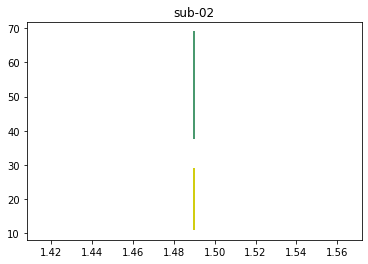

In [21]:
# multiple line plots

plt.plot( 'time_window', 'average_accuracy', data=df, marker='', 
         color='#4a996f', linewidth=2, label='Average accuracy')
plt.plot( 'time_window', 'average_loss', data=df, marker='', color='#d1cd10', 
         linewidth=2, linestyle='dashed', label='Average loss')
plt.title(subject, 'all 21 conditions')
plt.xlabel("Window time(sec)")

# show legend
plt.legend()

# show graph
plt.show()